# DP-SGD vs. Baseline Training on CelebA

This notebook compares standard training with Differential Privacy SGD (DP-SGD) on the CelebA eyeglasses classification task. We use **matched hyperparameters** and the **AdamW optimizer** for both approaches to isolate the privacy-accuracy trade-off.

> **💡 Tip:** This notebook uses collapsible sections (click the headers to expand/collapse) to keep setup and utility scripts organized. You can collapse sections you've already run to focus on the current workflow step.

<details style="border: 1px solid currentColor; border-radius: 6px; padding: 12px; margin: 10px 0;">
<summary style="font-size: 1.1em; font-weight: bold; cursor: pointer; padding: 8px;"><a id="why-privacy-matters"></a>🔒 Why Does Privacy in Machine Learning Matter?</summary>

**The Problem:** Standard machine learning models can leak sensitive information about their training data, even after training is complete.

**Real-World Risks:**

1. **Membership Inference Attacks**: An attacker can determine whether a specific person's data was used to train the model. For example:
   - A healthcare model trained on patient records could reveal if your medical data was in the training set
   - A face recognition model could reveal if your photo was used for training
   - 📚 Learn more: [Shokri et al. (2017) - Membership Inference Attacks](https://arxiv.org/abs/1610.05820)

2. **Model Inversion Attacks**: Attackers can reconstruct training examples from the model. For instance:
   - A model trained on medical images might allow reconstruction of patient faces
   - A language model might reproduce verbatim text from training data
   - 📚 Learn more: [Fredrikson et al. (2015) - Model Inversion Attacks](https://www.cs.cmu.edu/~mfredrik/papers/fjr2015ccs.pdf)

3. **Attribute Inference**: Models can reveal sensitive attributes about individuals:
   - A model trained on public photos might leak private attributes (e.g., location, relationships)
   - Financial models might reveal income or spending patterns
   - 📚 Learn more: [Fredrikson et al. (2014) - Privacy in Pharmacogenetics](https://www.cs.cmu.edu/~mfredrik/papers/fjr2014icml.pdf)

**Why This Matters for CelebA:**
CelebA contains celebrity photos with attributes. Without privacy protection, a trained model could:
- Reveal which celebrities were in the training set
- Potentially reconstruct training images
- Leak sensitive attributes about individuals

**The Solution:** Differential Privacy provides mathematical guarantees that individual training examples cannot be identified or reconstructed from the model, even by sophisticated attackers. 📚 Learn more: [Dwork & Roth (2014) - The Algorithmic Foundations of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf)

</details>

<details style="border: 1px solid currentColor; border-radius: 6px; padding: 12px; margin: 10px 0;">
<summary style="font-size: 1.1em; font-weight: bold; cursor: pointer; padding: 8px;"><a id="what-is-differential-privacy"></a>📊 What is Differential Privacy? (Intuitive Explanation)</summary>

**The Core Idea:** Differential Privacy ensures that the output of an algorithm (like a trained model) is **nearly identical** whether or not any single individual's data was included in the training set.

**The "Neighbor" Analogy:**
Imagine two training datasets that differ by exactly one person's data (these are called "neighboring datasets"). A differentially private algorithm produces outputs that are so similar for both datasets that an attacker cannot tell which dataset was used—and therefore cannot identify any individual.

**The Privacy Parameter (ε, epsilon):**
- **Lower ε = Stronger Privacy**: ε=0.1 means very strong privacy (outputs are nearly identical)
- **Higher ε = Weaker Privacy**: ε=10 means weaker privacy (more information can leak)
- **Common Values**: 
  - ε < 1: Very strong privacy (used for sensitive data like medical records)
  - ε = 1-10: Moderate privacy (common for many applications)
  - ε > 10: Weak privacy (may not provide meaningful protection)

**Key Property:** Differential Privacy is **compositional**—if you use a private algorithm multiple times, you can track the total privacy budget consumed (ε_total = ε₁ + ε₂ + ...).

**Why It's Powerful:** Unlike ad-hoc privacy techniques, differential privacy provides **mathematical guarantees** that hold even against attackers with unlimited computational power and background knowledge. 📚 Learn more: [Dwork (2006) - Differential Privacy](https://www.microsoft.com/en-us/research/publication/differential-privacy/) | [Dwork & Roth Textbook](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) | [NIST Privacy Engineering Guide](https://www.nist.gov/publications/differential-privacy-sharing-practices)

</details>

<details style="border: 1px solid currentColor; border-radius: 6px; padding: 12px; margin: 10px 0;">
<summary style="font-size: 1.1em; font-weight: bold; cursor: pointer; padding: 8px;"><a id="what-is-dp-sgd"></a>💭 What is DP-SGD?</summary>

**Differential Privacy SGD (DP-SGD)** is a privacy-preserving machine learning algorithm that provides formal privacy guarantees during training. It modifies standard SGD by:
- **Clipping gradients** to bound their sensitivity
- **Adding calibrated noise** to gradients before updating model parameters
- **Tracking privacy budget** (epsilon, ε) consumed during training
- 📚 Learn more: [Abadi et al. (2016) - Deep Learning with Differential Privacy](https://arxiv.org/abs/1607.00133)

**How It Works (Step-by-Step):**

1. **Standard SGD**: Computes gradients from a batch of training examples
2. **Gradient Clipping**: Limits the maximum influence of any single example by clipping gradients to a fixed norm (e.g., 1.0)
3. **Noise Addition**: Adds carefully calibrated Gaussian noise to the clipped gradients
4. **Parameter Update**: Updates model parameters using the noisy gradients
5. **Privacy Accounting**: Tracks how much privacy budget (ε) has been consumed

**The Intuition:**
- **Clipping** ensures no single example can have too much influence
- **Noise** makes it impossible to determine which examples contributed to the gradient
- **Accounting** ensures you know exactly how much privacy you've used

**What It Protects Against:**
- ✅ Membership inference attacks (can't tell if a specific example was in training)
- ✅ Model inversion attacks (can't reconstruct training examples)
- ✅ Attribute inference (can't infer sensitive attributes about individuals)

**The Trade-off:**
Privacy comes at the cost of some accuracy. The noise in gradients makes training less efficient, and the model may converge to a slightly lower accuracy. This notebook quantifies this trade-off through matched-pair comparisons.

**Implementation Resources:**
- 📚 [Opacus - PyTorch Privacy Library](https://opacus.ai/) - Official library for DP-SGD in PyTorch
- 📚 [Opacus Documentation](https://opacus.ai/api/) - API reference and tutorials
- 📚 [TensorFlow Privacy](https://github.com/tensorflow/privacy) - DP-SGD implementation for TensorFlow
- 📚 [Rényi Differential Privacy](https://arxiv.org/abs/1702.07476) - Advanced privacy accounting used by Opacus

</details>


</details>

<details style="border: 1px solid currentColor; border-radius: 6px; padding: 12px; margin: 10px 0;">
<summary style="font-size: 1.1em; font-weight: bold; cursor: pointer; padding: 8px;"><a id="why-eyeglasses"></a>👓 Why Eyeglasses?</summary>

The eyeglasses attribute provides a balanced binary classification task with less cultural bias than alternatives (e.g., smile detection), making it suitable for evaluating privacy-preserving methods.

</details>


<details style="border: 1px solid currentColor; border-radius: 6px; padding: 12px; margin: 10px 0;">
<summary style="font-size: 1.1em; font-weight: bold; cursor: pointer; padding: 8px;"><a id="workflow-overview"></a>🔀 Workflow Overview</summary>

**Setup** → **Data Pipeline** → **Training** → **Analysis**

1. **Setup**: Environment configuration and paths
2. **Data Pipeline**: Archive review → balanced subset → preprocessing → validation
3. **Training**: Baseline (non-private) and DP-SGD (privacy-preserving) with identical hyperparameters
4. **Analysis**: Matched-pair comparison quantifying privacy cost

</details>

<details style="border: 1px solid currentColor; border-radius: 6px; padding: 12px; margin: 10px 0;">
<summary style="font-size: 1.1em; font-weight: bold; cursor: pointer; padding: 8px;"><a id="prerequisites"></a>✅ Prerequisites</summary>

- CelebA dataset at `data/celeba/archive/`
- Run cells sequentially from top to bottom
- Dependencies: `src/*` modules

</details>

<details style="border: 1px solid currentColor; border-radius: 6px; padding: 12px; margin: 10px 0;">
<summary style="font-size: 1.1em; font-weight: bold; cursor: pointer; padding: 8px;"><a id="table-of-contents"></a>🗂️ Table of Contents</summary>

## [0. Introduction](#introduction)
- [0.1. Understanding DP-SGD: A Visual Demonstration](#dp-sgd-demo)

## [1. Setup](#setup)

## [2. Data Pipeline](#data-pipeline)
- [2.1. Review the Archive](#review-the-archive)
- [2.2. Build Subset](#build-subset)
- [2.3. Analyze the Subset (Before Preprocessing)](#analyze-the-subset-before-preprocessing)
- [2.4. Center-Crop Diagnostics (Optional)](#center-crop-diagnostics-optional)
- [2.5. Preprocess Images](#preprocess-images)
- [2.6. Validate Preprocessing](#validate-preprocessing)

## [3. Training](#training)
- [3.1 Baseline Training](#baseline-training)
  - [3.1.1. Quick Run: Baseline Training](#quick-run-baseline-training)
  - [3.1.2. Long Run: Baseline Training](#long-run-baseline-training)
- [3.2 DP-SGD Training](#dp-sgd-training)
  - [3.2.1. Quick Run: DP-SGD Training](#quick-run-dp-sgd-training)
  - [3.2.2. Long Run: DP-SGD Training](#long-run-dp-sgd-training)

## [4. Analysis](#analysis)
- [4.1. Matched Pair Analysis](#matched-pair-analysis)
- [4.2. Training Dynamics Comparison](#training-dynamics-comparison)
- [4.3. Privacy-Accuracy Trade-off](#privacy-accuracy-trade-off)
- [4.4. Summary](#summary)

</details>


# <a id="introduction"></a>Introduction

### <a id="dp-sgd-demo"></a> Understanding DP-SGD: A Visual Demonstration

Okay, before we get started with the full workflow, let's understand the core mechanisms of DP-SGD through a hands-on demonstration. This will help you visualize how **gradient clipping** and **noise addition** work together to provide privacy guarantees.

**What you'll see:**
1. **Original gradients**: Simulated gradients from a batch (some may be large)
2. **Clipped gradients**: Gradients after clipping to max norm (bounded influence)
3. **Noisy gradients**: Clipped gradients with Gaussian noise added (privacy protection)
4. **Comparison**: Visual comparison showing how clipping and noise affect gradients

Run the code cell below to see these concepts in action!


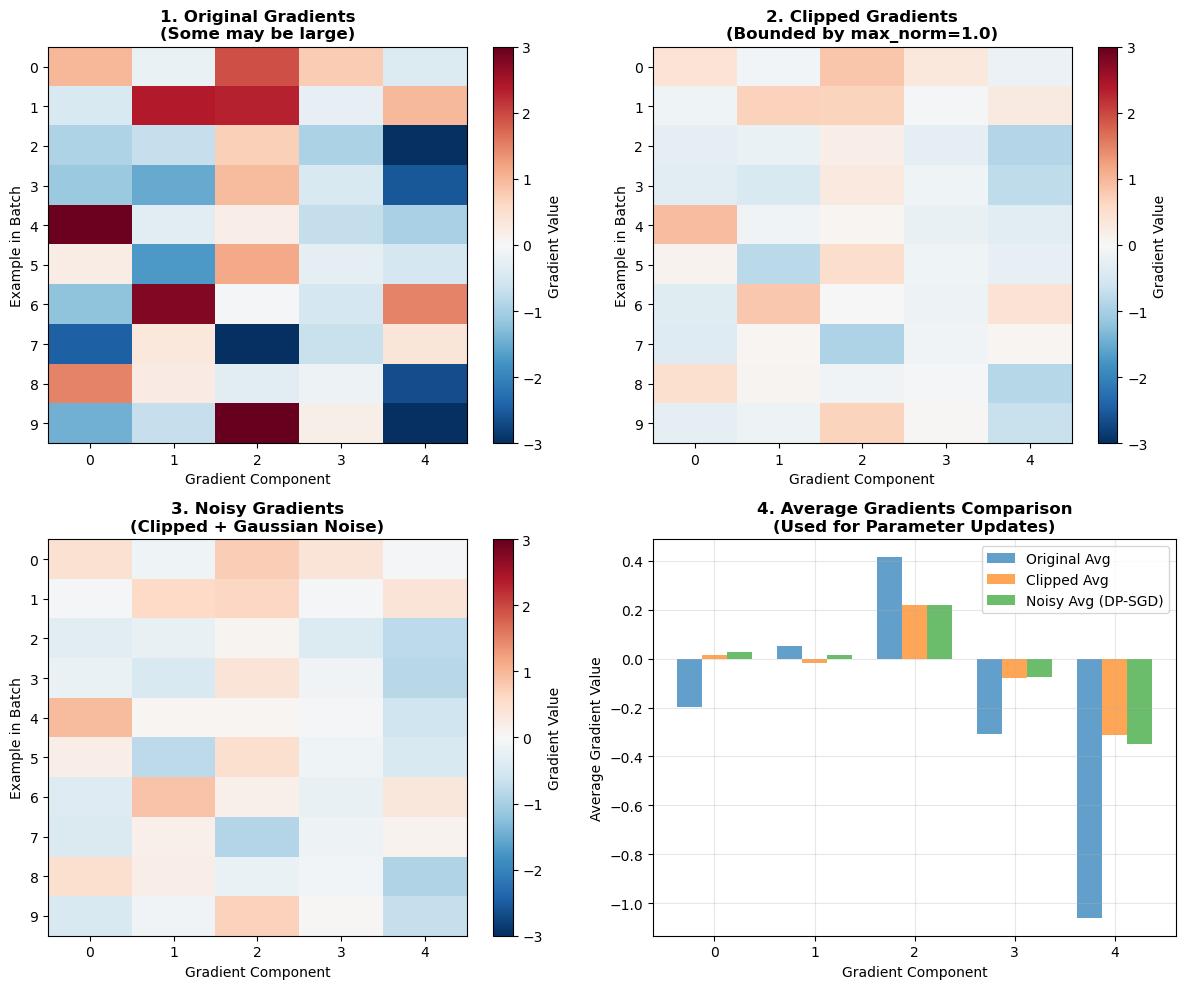

📊 Summary Statistics:
   Original gradient norms: min=2.160, max=6.418, mean=3.573
   Clipped gradient norms:   min=1.000, max=1.000, mean=1.000
   Noise scale: 0.1100 (noise_multiplier=1.1, max_grad_norm=1.0, batch_size=10)

💡 Key Insight:
   • Clipping bounds each example's influence (max norm = 1.0)
   • Noise makes it impossible to identify which examples contributed
   • The average noisy gradient is used for parameter updates (provides privacy)


In [1]:
# --- Educational Demo: Gradient Clipping and Noise Addition in DP-SGD ---
# This cell demonstrates the core mechanisms of DP-SGD without requiring full training setup.
# It shows how gradients are clipped and noise is added to provide privacy guarantees.

import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulate gradients from a batch (some examples may have large gradients)
# In real training, these would come from backpropagation
batch_size = 10
grad_dim = 5  # Simplified: just 5 gradient components
original_gradients = np.random.randn(batch_size, grad_dim) * np.array([2, 1.5, 3, 0.5, 1.8])[None, :]

# DP-SGD Step 1: Clip gradients to max norm (e.g., 1.0)
max_grad_norm = 1.0
gradient_norms = np.linalg.norm(original_gradients, axis=1, keepdims=True)
clipping_factor = np.minimum(1.0, max_grad_norm / (gradient_norms + 1e-8))
clipped_gradients = original_gradients * clipping_factor

# DP-SGD Step 2: Add calibrated Gaussian noise
noise_multiplier = 1.1
# In DP-SGD, noise scale = noise_multiplier * max_grad_norm / batch_size
noise_scale = noise_multiplier * max_grad_norm / batch_size
noise = np.random.normal(0, noise_scale, clipped_gradients.shape)
noisy_gradients = clipped_gradients + noise

# Compute average gradients (what would be used for parameter updates)
avg_original = np.mean(original_gradients, axis=0)
avg_clipped = np.mean(clipped_gradients, axis=0)
avg_noisy = np.mean(noisy_gradients, axis=0)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Original gradients (before clipping)
ax = axes[0, 0]
im1 = ax.imshow(original_gradients, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
ax.set_title('1. Original Gradients\n(Some may be large)', fontsize=12, fontweight='bold')
ax.set_xlabel('Gradient Component')
ax.set_ylabel('Example in Batch')
ax.set_yticks(range(batch_size))
plt.colorbar(im1, ax=ax, label='Gradient Value')

# Plot 2: Clipped gradients
ax = axes[0, 1]
im2 = ax.imshow(clipped_gradients, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
ax.set_title('2. Clipped Gradients\n(Bounded by max_norm=1.0)', fontsize=12, fontweight='bold')
ax.set_xlabel('Gradient Component')
ax.set_ylabel('Example in Batch')
ax.set_yticks(range(batch_size))
plt.colorbar(im2, ax=ax, label='Gradient Value')

# Plot 3: Noisy gradients (final DP-SGD gradients)
ax = axes[1, 0]
im3 = ax.imshow(noisy_gradients, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
ax.set_title('3. Noisy Gradients\n(Clipped + Gaussian Noise)', fontsize=12, fontweight='bold')
ax.set_xlabel('Gradient Component')
ax.set_ylabel('Example in Batch')
ax.set_yticks(range(batch_size))
plt.colorbar(im3, ax=ax, label='Gradient Value')

# Plot 4: Average gradients comparison
ax = axes[1, 1]
x = np.arange(grad_dim)
width = 0.25
ax.bar(x - width, avg_original, width, label='Original Avg', alpha=0.7)
ax.bar(x, avg_clipped, width, label='Clipped Avg', alpha=0.7)
ax.bar(x + width, avg_noisy, width, label='Noisy Avg (DP-SGD)', alpha=0.7)
ax.set_title('4. Average Gradients Comparison\n(Used for Parameter Updates)', fontsize=12, fontweight='bold')
ax.set_xlabel('Gradient Component')
ax.set_ylabel('Average Gradient Value')
ax.set_xticks(x)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("📊 Summary Statistics:")
print(f"   Original gradient norms: min={np.min(gradient_norms):.3f}, max={np.max(gradient_norms):.3f}, mean={np.mean(gradient_norms):.3f}")
print(f"   Clipped gradient norms:   min={np.min(np.linalg.norm(clipped_gradients, axis=1)):.3f}, max={np.max(np.linalg.norm(clipped_gradients, axis=1)):.3f}, mean={np.mean(np.linalg.norm(clipped_gradients, axis=1)):.3f}")
print(f"   Noise scale: {noise_scale:.4f} (noise_multiplier={noise_multiplier}, max_grad_norm={max_grad_norm}, batch_size={batch_size})")
print(f"\n💡 Key Insight:")
print(f"   • Clipping bounds each example's influence (max norm = {max_grad_norm})")
print(f"   • Noise makes it impossible to identify which examples contributed")
print(f"   • The average noisy gradient is used for parameter updates (provides privacy)")


---

Okay, let's get started! Now that we understand how **DP-SGD** works, let's set up the environment and begin the full workflow. The next cells will configure paths, imports, and prepare everything we need for training.


# <a id="setup"></a>1. Setup

The setup cells below configure the environment and prepare everything needed for the workflow.

**What's included:**
- **Environment**: Path configuration, imports, logging, and YAML config loading
- **Reproducibility**: Random seeding for Python, NumPy, and PyTorch
- **Data paths**: Directory creation and workflow configuration initialization

**Checks performed:**
- ✅ Repository structure and module imports
- ✅ Required dependencies (matplotlib, torch, etc.)
- ✅ Directory creation and path validation

Run the setup cells below to initialize the environment. You'll see confirmation messages when setup completes successfully.


In [2]:
# --- Environment Setup: Paths, Imports, Logging, and Seeding ---
import sys
import logging
import random
from pathlib import Path

# --- Path Setup: Must be done before importing from src ---
def find_repo_root(start: Path) -> Path:
    """Find the repository root by looking for the 'src' directory."""
    for candidate in [start, *start.parents]:
        if (candidate / "src").exists():
            return candidate
    raise RuntimeError("Could not locate repository root containing a 'src' directory.")

# Find and set up repository root
PROJECT_ROOT = find_repo_root(Path.cwd())

# Ensure repo root is on sys.path (front)
root_str = str(PROJECT_ROOT)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

# Third-party imports
import numpy as np
try:
    import matplotlib.pyplot as plt
except ImportError as e:
    raise ImportError("matplotlib is required. Try: pip install matplotlib") from e

# Import centralized configuration (now that path is set up)
from src.config import get_config

# Get configuration
config = get_config()

# Logging setup: notebooks can re-run cells, so reset handlers
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s", force=True)
logger = logging.getLogger("setup")

# Basic seeding from configuration
RANDOM_SEED = config.random_seed
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Optional torch seeding (if available)
try:
    import torch
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    # Torch isn't required for this cell; skip silently if absent
    pass

# --- Matplotlib Configuration ---
# Configure matplotlib style from configuration
try:
    plt.style.use(config.matplotlib_style)
    logger.info(f"Using matplotlib style: {config.matplotlib_style}")
except Exception:
    plt.style.use(config.matplotlib_style_fallback)
    logger.info(f"Using fallback matplotlib style: {config.matplotlib_style_fallback}")

# Set figure DPI from configuration
plt.rcParams["figure.dpi"] = config.figure_dpi

# --- Path Verification and Summary ---
repo_name = Path(PROJECT_ROOT).name
logger.info(f"Repository root: {repo_name}")
logger.info(f"Python path includes: {repo_name}")
logger.info(f"Matplotlib configured - DPI: {config.figure_dpi}")
logger.info(f"Environment setup complete. Random seed: {RANDOM_SEED}")


INFO: Using matplotlib style: seaborn-v0_8-whitegrid
INFO: Repository root: dp_sgd_classification
INFO: Python path includes: dp_sgd_classification
INFO: Matplotlib configured - DPI: 120
INFO: Environment setup complete. Random seed: 42


In [3]:
# --- Data Paths and Workflow Configuration ---
# This cell sets up data paths, creates directories, imports workflow helpers, and creates the Config object.

import importlib
from src.notebooks.display import _relpath as _rp

# Generate paths from centralized configuration
paths = config.get_paths(PROJECT_ROOT)
ARCHIVE_DIR = paths["archive_dir"]
IMAGES_ROOT = paths["images_root"]
OUTPUT_DIR = paths["output_dir"]
OUT_ROOT = paths["out_root"]

# Ensure directories exist
for p in (OUTPUT_DIR, OUT_ROOT):
    p.mkdir(parents=True, exist_ok=True)

# Import workflow helpers
try:
    import src.datasets.celeba.workflow as _cw
    _cw = importlib.reload(_cw)
except Exception as e:
    raise ImportError(
        "Failed to import or reload 'src.datasets.celeba.workflow'. "
        "Check that 'src/' is under the repo root and module imports are valid."
    ) from e

from src.datasets.celeba.workflow import (
    Config,
    review_archive
)

# Create workflow config using centralized values and paths
cfg = Config(
    archive_dir=ARCHIVE_DIR,
    images_root=IMAGES_ROOT,
    output_dir=OUTPUT_DIR,
    subset_root=OUTPUT_DIR,
    out_root=OUT_ROOT,
    attribute=config.attribute,
    max_train=config.max_train_per_class,
    max_val=config.max_val_per_class,
    max_test=config.max_test_per_class,
    link_mode=config.link_mode,
    random_seed=config.random_seed,
)

logger.info("Configuration ready.")

INFO: Configuration ready.


In [4]:
# --- Preview key config values ---
# Display workflow configuration for verification before proceeding

from src.notebooks import print_config

print("Paths:")
print(f"  - archive_dir: {_rp(cfg.archive_dir)}")
print(f"  - images_root: {_rp(cfg.images_root)}")
print(f"  - subset_root: {_rp(cfg.subset_root)}")
print(f"  - out_root: {_rp(cfg.out_root)}")

print("\nSubset caps (per class):")
print_config("", {"train": cfg.max_train, "val": cfg.max_val, "test": cfg.max_test}, indent=2)

print("\nPreprocess:")
print_config("", {
    "size": cfg.preprocess_size,
    "center_crop": cfg.preprocess_center_crop,
    "normalize_01": cfg.preprocess_normalize_01,
    "compute_stats": cfg.preprocess_compute_stats
}, indent=2)

print("\nFlags:")
print_config("", {"plot": cfg.plot, "dry_run": cfg.dry_run, "overwrite": cfg.overwrite}, indent=2)


Paths:
  - archive_dir: data/celeba/archive
  - images_root: data/celeba/archive/img_align_celeba/img_align_celeba
  - subset_root: data/celeba/subsets/eyeglasses_balanced_20k
  - out_root: data/celeba/processed/eyeglasses_balanced_20k_64

Subset caps (per class):
  :
    train: 8000
    val: 1000
    test: 1000

Preprocess:
  :
    size: 64
    center_crop: True
    normalize_01: True
    compute_stats: True

Flags:
  :
    plot: True
    dry_run: False
    overwrite: True


# <a id="data-pipeline"></a>2. Data Pipeline


## <a id="review-the-archive"></a>2.1. Review the Archive

Examine the original CelebA dataset to assess attribute distributions and data integrity before subset creation.

**Steps:**
1. **Quick Visual Check (Optional)**: Sample 3 random images to verify accessibility
2. **Full Archive Review**: Scan attribute distributions, validate data health, generate receipts

**Key checks:**
- Required CSV files present (`list_attr_celeba.csv`, `list_eval_partition.csv`)
- Attribute balance: Eyeglasses is rare (~6-7% overall), requiring balanced sampling
- Split consistency: Attribute distribution stable across train/val/test
- Receipts: Summary files and plots for audit trail

Found 182599 images in data/celeba/archive/img_align_celeba/img_align_celeba
Randomly sampled 3 images for verification:

  ✓ 031008.jpg (178×218) - data/celeba/archive/img_align_celeba/img_align_celeba/031008.jpg
  ✓ 073018.jpg (178×218) - data/celeba/archive/img_align_celeba/img_align_celeba/073018.jpg
  ✓ 057619.jpg (178×218) - data/celeba/archive/img_align_celeba/img_align_celeba/057619.jpg


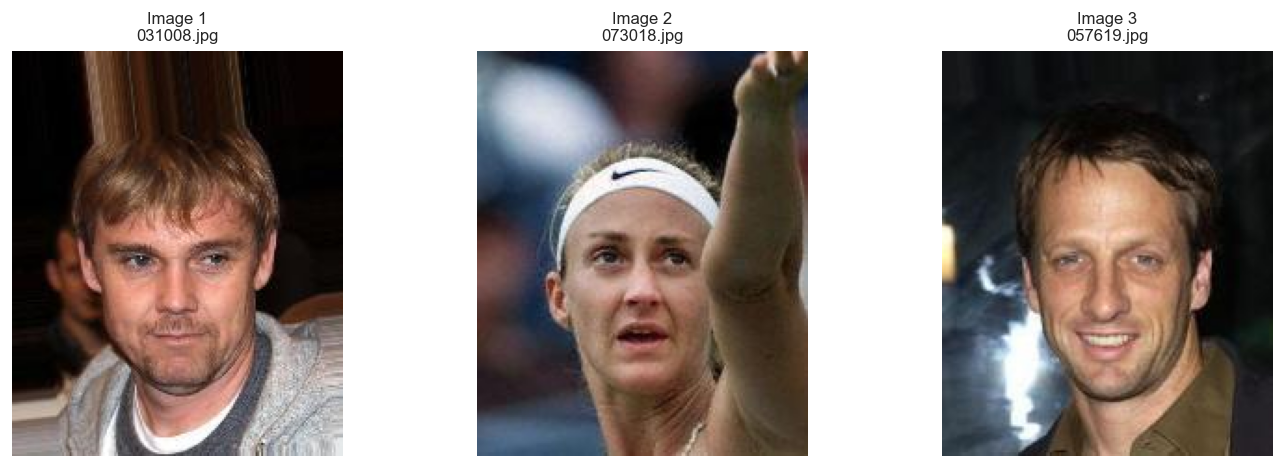


✅ Dataset verification complete: 3 images successfully loaded.


In [5]:
# --- Quick Visual Check (Optional): Sample images to verify dataset is accessible ---
# This is a quick smoke test before the full archive review. You can skip this if confident the dataset is accessible.

from PIL import Image
import matplotlib.pyplot as plt
from src.notebooks.display import _relpath as _rp, find_and_sample_images

# Configuration constants
VISUAL_CHECK_SAMPLES = 3  # Number of images to sample for visual verification
FIG_WIDTH_PER_IMAGE = 4  # Figure width multiplier per image
FIG_HEIGHT = 4  # Figure height
TITLE_FONTSIZE = 10  # Font size for image titles

# Find and sample images using helper function
sampled_images, total_count = find_and_sample_images(
    cfg.images_root,
    n_samples=VISUAL_CHECK_SAMPLES,
    seed=config.random_seed
)

print(f"Found {total_count} images in {_rp(cfg.images_root)}")
print(f"Randomly sampled {len(sampled_images)} images for verification:\n")

# Display the sampled images
fig, axes = plt.subplots(1, len(sampled_images), figsize=(FIG_WIDTH_PER_IMAGE * len(sampled_images), FIG_HEIGHT))
if len(sampled_images) == 1:
    axes = [axes]

for idx, img_path in enumerate(sampled_images):
    try:
        # Load and display the image
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Image {idx + 1}\n{img_path.name}", fontsize=TITLE_FONTSIZE)
        axes[idx].axis('off')
        print(f"  ✓ {img_path.name} ({img.size[0]}×{img.size[1]}) - {_rp(img_path)}")
    except Exception as e:
        axes[idx].text(0.5, 0.5, f"Error loading\n{img_path.name}\n{str(e)}", 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].axis('off')
        print(f"  ✗ {img_path.name} - Error: {e}")

plt.tight_layout()
plt.show()

print(f"\n✅ Dataset verification complete: {len(sampled_images)} images successfully loaded.")


Review archive:
  archive_dir: data/celeba/archive
  plot_top_n_attrs: 20
- All required files found (including optional files)

- 202,599 images, 40 attributes   •   Test: 19,962 | Train: 162,770 | Val: 19,867


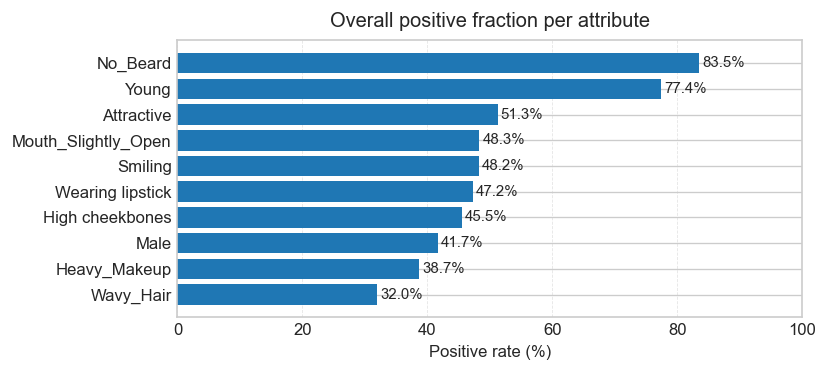

Attribute,Overall %,Train %,Val %,Test %,Δ Train (pp),Δ Val (pp),Δ Test (pp)
Young,77.4%,77.9%,74.7%,75.7%,+0.5,-2.7,-1.6
Smiling,48.2%,48.0%,48.3%,50.0%,-0.2,+0.1,+1.8
Male,41.7%,41.9%,42.6%,38.6%,+0.3,+0.9,-3.0
Heavy_Makeup,38.7%,38.4%,39.0%,40.5%,-0.3,+0.3,+1.8
Blond_Hair,14.8%,14.9%,15.4%,13.3%,+0.1,+0.6,-1.5
Eyeglasses,6.5%,6.5%,7.0%,6.5%,-0.0,+0.4,-0.1


INFO: Archive review complete.



- Saved: data/celeba/archive/celeba_balance_summary.csv   •   plots → data/celeba/archive/balance_plots


In [6]:
# --- Review archive: scan attribute distributions and check data health ---
# This cell performs the full archive review (can be collapsed after first run)

from src.notebooks.display import _relpath as _rp
from src.notebooks import print_config

print_config("Review archive", {
    "archive_dir": _rp(cfg.archive_dir),
    "plot_top_n_attrs": config.plot_top_n_attrs
})

review_archive(cfg)

## <a id="build-subset"></a>2.2. Build Subset

Create a balanced eyeglasses subset with target class caps per split. Missing or inaccessible files are logged for accountability.

**Output:**
- Balanced 50/50 splits (eyeglasses vs no_eyeglasses) for train/val/test
- Audit trail: `subset_index_eyeglasses.csv` with full record
- Skipped files: `skipped_missing_images.csv` (verify if count is unexpectedly large)

In [7]:
# --- Build balanced eyeglasses subset ---
# Creates a balanced 50/50 subset with target class caps per split.
# Missing or inaccessible files are logged to skipped_missing_images.csv.

from src.datasets.celeba.workflow import build_subset_with_skip_summary
from src.notebooks import print_config

subset_config = config.get_subset_config()
print_config("Build subset", {
    "attribute": subset_config["attribute"],
    "max_train": subset_config["max_train_per_class"],
    "max_val": subset_config["max_val_per_class"],
    "max_test": subset_config["max_test_per_class"],
    "link_mode": subset_config["link_mode"],
    "overwrite": cfg.overwrite,
    "dry_run": cfg.dry_run,
    "output_dir": _rp(cfg.output_dir),
})

# Capture and summarize skipped images; write skipped_missing_images.csv
build_subset_with_skip_summary(cfg, suppress_per_file_logs=True)


Build subset:
  attribute: Eyeglasses
  max_train: 8000
  max_val: 1000
  max_test: 1000
  link_mode: copy
  overwrite: True
  dry_run: False
  output_dir: data/celeba/subsets/eyeglasses_balanced_20k
- Built balanced subset: 20,000 images
- Train: 16,000 (8,000/8,000) | Val: 2,000 (1,000/1,000) | Test: 2,000 (1,000/1,000)
- Output: notebooks/data/celeba/subsets/eyeglasses_balanced_20k
- Skipped: 1,963 missing images (see data/celeba/subsets/eyeglasses_balanced_20k/skipped_missing_images.csv)


## <a id="analyze-the-subset-before-preprocessing"></a>2.3. Analyze the Subset (Before Preprocessing)

Now that the subset is built, we pause to measure it directly. This is the **working dataset** we'll actually train on. Catching size quirks or odd channel stats here is cheaper than discovering them mid-training.

If the subset appears clean, balanced, and predictable, proceed with preprocessing.

In [8]:
# --- Analyze subset before preprocessing ---
# Measures the working dataset directly: counts, geometry, format, and class balance.
# This is the dataset we'll actually train on, so catching issues here is cheaper than mid-training.

from src.datasets.celeba.workflow import analyze_original_subset

analyze_original_subset(cfg, verbosity="brief")


• Counts: 20k total images (16k train, 2k val, 2k test) | 50/50 class balance
• Geometry: 178×218 pixels (uniform)
• Format: JPEG (RGB, 3 bands)


## <a id="center-crop-diagnostics-optional"></a>2.4. Center-Crop Diagnostics (Optional)

Cropping is a design choice that affects what information the model sees. This diagnostic shows what the crop removes and whether the label of interest survives intact.

**What to check:**
- Averaged images pre/post crop should preserve the region of interest
- Difference heatmaps show where pixels are lost (typically margins)
- For eyeglasses, the crop should keep the face region centered

If important content consistently falls outside the crop, consider padding instead of hard square cropping.

Diagnostics preview:
  target_size: 64
  sample: 256


Averaging images (original & cropped): 100%|██████████| 256/256 [00:00<00:00, 1014.96it/s]


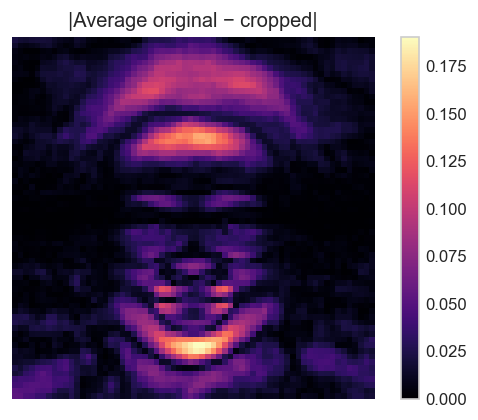

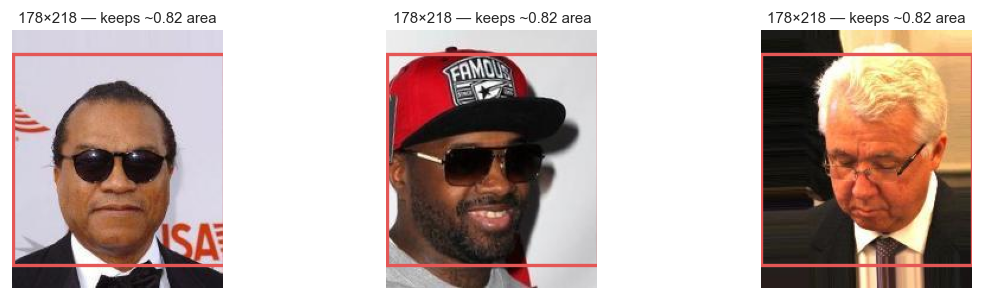

In [9]:
# --- Center-crop diagnostics (optional) ---
# Shows what the crop removes and whether the label of interest survives intact.
# Displays averaged images pre/post crop and difference heatmaps.

from src.datasets.celeba.workflow import preview_center_crop_diagnostics
from src.notebooks import print_config

print_config("Diagnostics preview", {
    "target_size": config.diag_target_size,
    "sample": config.diag_visual_sample
})

preview_center_crop_diagnostics(cfg)



## <a id="preprocess-images"></a>2.5. Preprocess Images

Apply standard preprocessing transformations to create a uniform dataset:

- **Center-crop → resize (64×64)**: Uniform scale and aspect ratio
- **Normalize to [0,1]**: Standard pixel scale for training
- **Compute channel mean/std**: Calculated on train split for normalization
- **Preserve split/class structure**: Maintains reproducibility and audit trail

**Output**: Processed images with index CSV and summary files for audit trail.

In [10]:
# --- Preprocess images ---
# Applies center-crop → resize (64×64), normalizes to [0,1], and computes channel statistics.
# Preserves split/class structure and generates index CSV and summary files for audit trail.

from src.datasets.celeba.workflow import preprocess_images_only

preprocess_images_only(cfg)


Measuring processed sizes: 100%|██████████| 20000/20000 [00:02<00:00, 8509.35it/s] 
INFO: Updated processed_index.csv with width/height columns


• Counts: 20k total images (16k train, 2k val, 2k test) | 50/50 class balance
• Geometry: 64×64 pixels (uniform)
• Format: JPEG (RGB, 3 bands)


## <a id="validate-preprocessing"></a>2.6. Validate Preprocessing

Quick validation of the processed dataset before training:

**Checks performed:**
- **Counts**: Total images and distribution across train/val/test splits with class balance
- **Geometry**: Image dimensions and uniformity (all images should be the same size)
- **Format**: Image file type and color channels (RGB)
- **Data integrity**: Images are valid and loadable

This provides a concise summary to confirm the dataset is ready for training. For detailed diagnostics, use the full analysis mode.

In [11]:
# --- Analyze processed dataset ---
# Quick validation: counts, geometry, format, and data integrity checks.
# Confirms dataset is ready for training. Use full analysis mode for detailed diagnostics.

from src.datasets.celeba.workflow import analyze_processed

analyze_processed(cfg, verbosity="brief")

Before → After Preprocessing:

• Counts: 20k total → 20k total (16k train, 2k val, 2k test) | 50/50 class balance
• Geometry: 178×218 → 64×64 pixels (uniform)
• Format: JPEG (RGB) → JPEG (RGB, 3 bands)


In [12]:
# --- Verify preprocessing artifacts exist ---
# Validates that required preprocessing output files (manifest, ledger) are present.
# These files are needed for training and analysis.

from pathlib import Path

MANIFEST_PATH = Path(cfg.out_root) / "stats" / "manifest.csv"
LEDGER_PATH = Path(cfg.out_root) / "stats" / "data_ledger.json"

if not MANIFEST_PATH.exists():
    raise FileNotFoundError(f"Missing preprocessing manifest: {MANIFEST_PATH}")
if not LEDGER_PATH.exists():
    raise FileNotFoundError(f"Missing preprocessing ledger: {LEDGER_PATH}")

print("✓ Preprocessing receipts verified")

✓ Preprocessing receipts verified


# <a id="training"></a>3. Training

This section covers model training using two approaches:

1. **Baseline Training**: Standard (non-private) training using AdamW optimizer
2. **DP-SGD Training**: Privacy-preserving training with differential privacy guarantees

**Matched Pair Design:**
Both approaches use **identical hyperparameters**, models, and data. This enables direct comparison to quantify the **privacy-accuracy trade-off**—how much accuracy we sacrifice for privacy protection.

**Training Options:**
Each approach offers quick (5 epochs) and long (20 epochs) runs:
- **Quick runs**: Fast demonstration of training dynamics
- **Long runs**: Extended training for better convergence and more accurate analysis

The analysis section will automatically use long run data when available for consistency.


## <a id="baseline-training"></a>3.1 Baseline Training

Train a non-private baseline using AdamW optimizer with a hyperparameter sweep. All configurations are identically replicated for DP-SGD training to isolate the privacy-accuracy trade-off.

**Why AdamW?** Same optimizer for both approaches ensures fair comparison. AdamW properly decouples weight decay and works seamlessly with Opacus PrivacyEngine.

**Configuration:**
- 6 matched configurations (each has an identical DP-SGD counterpart)
- Hyperparameters: Learning rates (0.0005-0.005), batch sizes (64, 128), weight decay (0.0, 0.0001)
- Uses processed dataset and channel statistics from preprocessing

**Training Options:**
You can run either the quick run, the long run, or both:
- **Quick (5 epochs)**: Fast demonstration of training dynamics
- **Long (20 epochs)**: Extended training for full convergence

**Note:** If you run both, the analysis cells will automatically use the long run data for consistency. The quick run is useful for quick exploration, while the long run provides better convergence patterns for analysis.


In [13]:
# --- Baseline Training: Setup (imports, device, paths, and loader helpers) ---
# Apply platform-specific workarounds automatically
# Getting the platform config automatically applies OpenMP workaround for M1 Macs

from src.config import get_platform_config, log_platform_info

# Initialize platform config (automatically applies workarounds)
platform_config = get_platform_config()
log_platform_info(logger)

from pathlib import Path
import pandas as pd
import torch
import random
import numpy as np
from IPython.display import display

from src.config import BaselineConfig
from src.core import load_stats, build_dataloaders, SimpleCNN, get_device, set_seed, accuracy, evaluate

# Device & seed from centralized configuration
DEVICE = get_device()
SEED = config.random_seed
set_seed(SEED)

# Processed dataset root and stats
PROCESSED_ROOT = str(cfg.out_root)
STATS_PATH = str(Path(cfg.out_root) / "stats" / "stats.json")

# Sanity prints
print({"device": str(DEVICE), "seed": SEED, "processed_root": _rp(PROCESSED_ROOT)})
assert Path(STATS_PATH).exists(), f"Missing stats file: {STATS_PATH}"

# Load channel stats once (used by all loaders)
MEAN, STD = load_stats(STATS_PATH)

# --- Loader helper (rebuilds for a given batch size) ---
# Define a top-level worker_init_fn so it is picklable under 'spawn' (macOS)
# The multiplier 9973 is a large prime number used to ensure different seeds for each worker
WORKER_SEED_MULTIPLIER = 9973  # Large prime for worker seed differentiation

def worker_init_fn(worker_id: int):
    """Initialize random seed for each dataloader worker to ensure reproducibility."""
    seed = (SEED + worker_id * WORKER_SEED_MULTIPLIER) % (2**32 - 1)
    random.seed(seed)
    np.random.seed(seed)


def make_loaders(batch_size: int, num_workers: int = 0,  # Disable multiprocessing for reliability
                 aug_flip: bool = True, aug_jitter: bool = False,
                 aug_rotation: bool = False, rotation_degrees: float = 10.0):
    """Create train/val/test dataloaders with specified batch size and augmentation.
    
    Args:
        batch_size: Number of samples per batch
        num_workers: Number of worker processes (0 disables multiprocessing for reliability on macOS)
        aug_flip: Whether to apply horizontal flip augmentation
        aug_jitter: Whether to apply color jitter augmentation
        aug_rotation: Whether to apply random rotation augmentation
        rotation_degrees: Maximum rotation angle in degrees (only used if aug_rotation=True)
        
    Returns:
        Tuple of (train_loader, val_loader, test_loader)
    """
    # Use num_workers=0 to avoid multiprocessing issues on macOS
    # This is slower but more reliable across platforms
    
    g = torch.Generator()
    g.manual_seed(SEED)
    return build_dataloaders(
        data_root=PROCESSED_ROOT,
        batch_size=batch_size,
        num_workers=num_workers,
        mean=MEAN,
        std=STD,
        aug_flip=aug_flip,
        aug_jitter=aug_jitter,
        aug_rotation=aug_rotation,
        rotation_degrees=rotation_degrees,
        worker_init_fn=worker_init_fn,
        generator=g,
    )

# Quick smoke test to verify loaders work correctly
train_loader, val_loader, test_loader = make_loaders(batch_size=64)
logger.info(f"Loaders created successfully: train={len(train_loader)} batches, val={len(val_loader)} batches, test={len(test_loader)} batches")


INFO: Platform: Darwin (arm64)
INFO: Multiprocessing method: spawn
INFO: M1 Mac detected - OpenMP workaround applied
INFO: Data loader config: 0 workers (macOS multiprocessing compatibility)
INFO: Loaders created successfully: train=250 batches, val=32 batches, test=32 batches


{'device': 'mps', 'seed': 42, 'processed_root': 'data/celeba/processed/eyeglasses_balanced_20k_64'}


In [14]:
# --- Training Infrastructure: Import Helper Modules ---
# All training functionality has been extracted to helper modules for better organization
# and reusability across different experiments.

from src.training import (
    run_sgd_sweep_with_progress,
    plot_training_curves
)

# Simple helper functions for this specific experiment
def make_model():
    """Create a SimpleCNN model for eyeglasses classification.
    
    Returns:
        SimpleCNN model moved to the configured device (CPU/GPU)
    """
    return SimpleCNN(num_classes=2).to(DEVICE)



/opt/anaconda3/envs/dp-sgd-py312-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### <a id="quick-run-baseline-training"></a>⚠️ 3.1.1 Quick Run: Baseline Training ⚠️

**This cell will run the quick baseline training (5 epochs).**

This is a fast demonstration that trains for 5 epochs. If you want to see full convergence patterns, you can also run the long training cell below. If you run both, the analysis cells will automatically use the long run data.


📋 Quick Run Configuration:
   :
     Epochs: 5
     Sweep ID: eyeglasses_baseline_v1_quick
     Configurations: 6 matched pairs
     Optimizer: AdamW (for fair comparison)

🚀 Starting Baseline (AdamW) Hyperparameter Sweep (6 runs)
📋 Sweep ID: eyeglasses_baseline_v1_quick

📊 Run 1/6: baseline_lr0.003_bs64_wd0
   Config: lr=0.003, bs=64, wd=0.0


✅ Completed: test_acc=0.9225, val_acc=0.9195, time=90.2s

📈 Progress: 1/6 runs completed

📊 Run 2/6: baseline_lr0.003_bs128_wd0.0001
   Config: lr=0.003, bs=128, wd=0.0001


✅ Completed: test_acc=0.8170, val_acc=0.7960, time=73.1s

📈 Progress: 2/6 runs completed

📊 Run 3/6: baseline_lr0.001_bs64_wd0.0001
   Config: lr=0.001, bs=64, wd=0.0001


✅ Completed: test_acc=0.9310, val_acc=0.9265, time=75.7s

📈 Progress: 3/6 runs completed

📊 Run 4/6: baseline_lr0.001_bs128_wd0
   Config: lr=0.001, bs=128, wd=0.0


✅ Completed: test_acc=0.8640, val_acc=0.8520, time=67.1s

📈 Progress: 4/6 runs completed

📊 Run 5/6: baseline_lr0.0005_bs64_wd0.0001
   Config: lr=0.0005, bs=64, wd=0.0001


✅ Completed: test_acc=0.8395, val_acc=0.8235, time=75.3s

📈 Progress: 5/6 runs completed

📊 Run 6/6: baseline_lr0.005_bs64_wd0
   Config: lr=0.005, bs=64, wd=0.0


✅ Completed: test_acc=0.7945, val_acc=0.7810, time=75.3s

🏆 TRAINING RUNS COMPLETED
✅ Run 1: baseline_lr0.003_bs64_wd0
   Test Acc: 0.9225 | Val Acc: 0.9195 | Time: 90.2s

✅ Run 2: baseline_lr0.003_bs128_wd0.0001
   Test Acc: 0.8170 | Val Acc: 0.7960 | Time: 73.1s

🥇 Run 3: baseline_lr0.001_bs64_wd0.0001
   Test Acc: 0.9310 | Val Acc: 0.9265 | Time: 75.7s

✅ Run 4: baseline_lr0.001_bs128_wd0
   Test Acc: 0.8640 | Val Acc: 0.8520 | Time: 67.1s

✅ Run 5: baseline_lr0.0005_bs64_wd0.0001
   Test Acc: 0.8395 | Val Acc: 0.8235 | Time: 75.3s

✅ Run 6: baseline_lr0.005_bs64_wd0
   Test Acc: 0.7945 | Val Acc: 0.7810 | Time: 75.3s

🎯 Best Run: baseline_lr0.001_bs64_wd0.0001 (Test Acc: 0.9310)

💾 Saved Run Artifacts:
   📁 runs/baseline/20251122_201733_baseline_lr0.003_bs64_wd0_eyeglasses_baseline_v1_quick
   📁 runs/baseline/20251122_201846_baseline_lr0.003_bs128_wd0.0001_eyeglasses_baseline_v1_quick
   📁 runs/baseline/20251122_202002_baseline_lr0.001_bs64_wd0.0001_eyeglasses_baseline_v1_quick
   

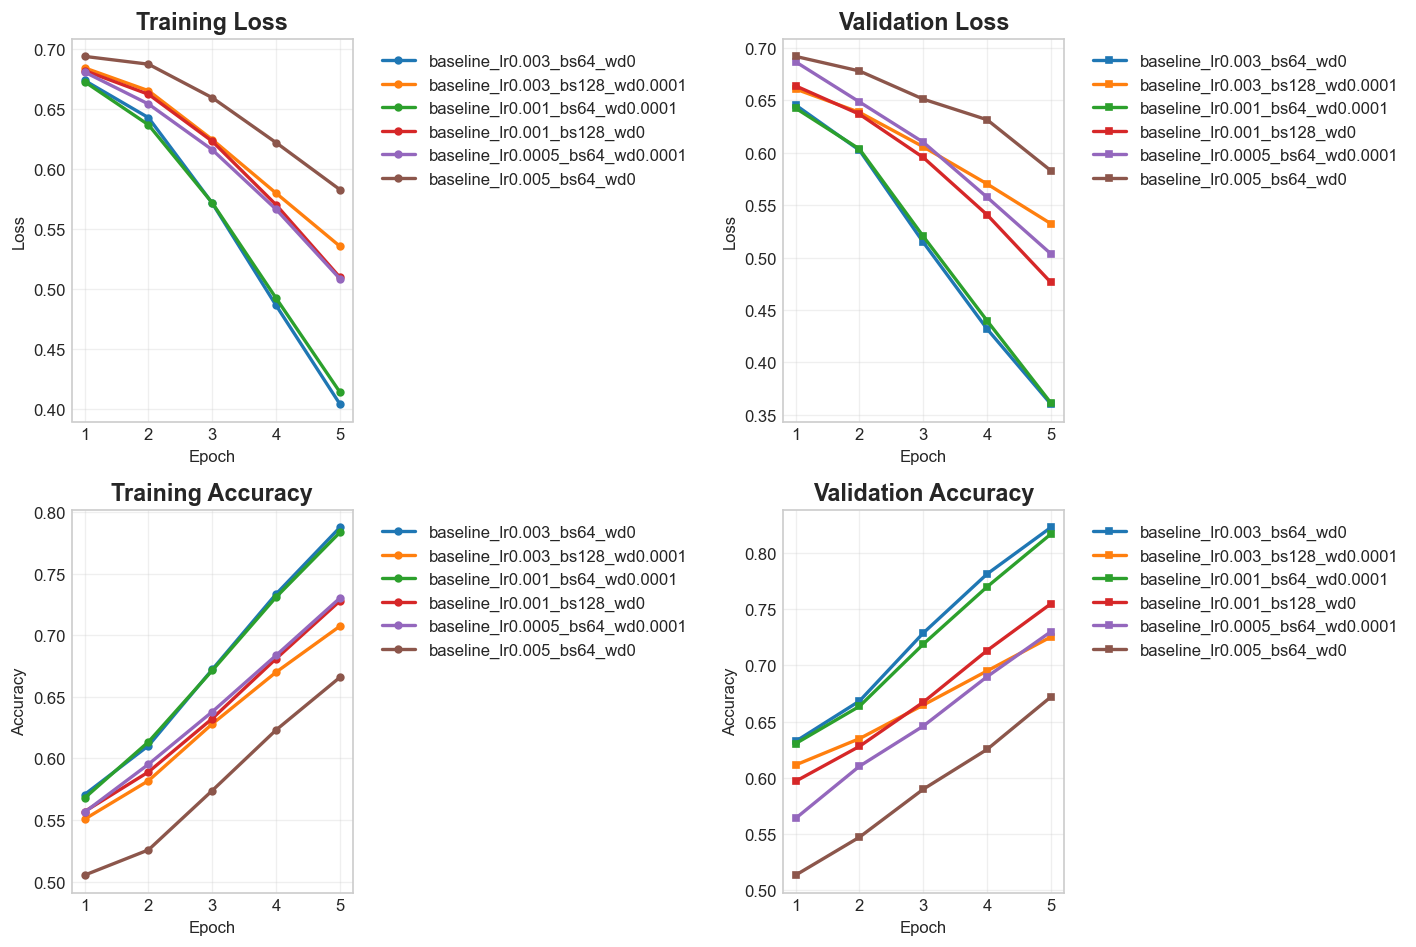

In [16]:
# --- Quick Run: Baseline Training (5 epochs) ---
# Fast demonstration with matched hyperparameter configurations.
# All configurations use AdamW optimizer for fair comparison with DP-SGD.

from src.notebooks import generate_timestamp, print_config

training_config = config.get_training_config(quick=True)

print("📋 Quick Run Configuration:")
print_config("", {
    "Epochs": training_config['epochs'],
    "Sweep ID": training_config['sweep_id'],
    "Configurations": f"{len(training_config['sweep_grid'])} matched pairs",
    "Optimizer": "AdamW (for fair comparison)"
}, indent=3)

# Use the refactored sweep function with centralized configuration
history_df_quick = run_sgd_sweep_with_progress(
    grid=training_config["sweep_grid"], 
    epochs=training_config["epochs"], 
    sweep_id=training_config["sweep_id"],
    device=DEVICE,
    make_model_fn=make_model,
    make_loaders_fn=make_loaders,
    num_workers=training_config["num_workers"],
    aug_flip=training_config["aug_flip"],
    aug_jitter=training_config["aug_jitter"],
    base_run_dir=training_config["base_run_dir"]
)

# Plot training curves
timestamp = generate_timestamp()
filename_quick = f"{timestamp}_baseline_quick_training_curves.png"
fig = plot_training_curves(history_df_quick, save_path=filename_quick)


### <a id="long-run-baseline-training"></a>⚠️ 3.1.2 Long Run: Baseline Training ⚠️

**This cell will run the long baseline training (20 epochs).**

This extended training provides better convergence patterns for analysis. You can run this instead of or in addition to the quick run above. If you run both, the analysis cells will automatically use this long run data.


📋 Longer Run Configuration:
   Epochs: 20
   Sweep ID: eyeglasses_baseline_v1_long
   Configurations: 6 matched pairs
   ⚠️  This will take significantly longer than the quick run

🚀 Starting Baseline (AdamW) Hyperparameter Sweep (6 runs)
📋 Sweep ID: eyeglasses_baseline_v1_long

📊 Run 1/6: baseline_lr0.003_bs64_wd0
   Config: lr=0.003, bs=64, wd=0.0


✅ Completed: test_acc=0.9580, val_acc=0.9600, time=330.4s

📈 Progress: 1/6 runs completed

📊 Run 2/6: baseline_lr0.003_bs128_wd0.0001
   Config: lr=0.003, bs=128, wd=0.0001


✅ Completed: test_acc=0.9620, val_acc=0.9575, time=286.2s

📈 Progress: 2/6 runs completed

📊 Run 3/6: baseline_lr0.001_bs64_wd0.0001
   Config: lr=0.001, bs=64, wd=0.0001


✅ Completed: test_acc=0.9715, val_acc=0.9650, time=311.7s

📈 Progress: 3/6 runs completed

📊 Run 4/6: baseline_lr0.001_bs128_wd0
   Config: lr=0.001, bs=128, wd=0.0


✅ Completed: test_acc=0.9670, val_acc=0.9635, time=280.4s

📈 Progress: 4/6 runs completed

📊 Run 5/6: baseline_lr0.0005_bs64_wd0.0001
   Config: lr=0.0005, bs=64, wd=0.0001


✅ Completed: test_acc=0.9555, val_acc=0.9555, time=302.5s

📈 Progress: 5/6 runs completed

📊 Run 6/6: baseline_lr0.005_bs64_wd0
   Config: lr=0.005, bs=64, wd=0.0


✅ Completed: test_acc=0.9590, val_acc=0.9470, time=323.9s

🏆 TRAINING RUNS COMPLETED
✅ Run 1: baseline_lr0.003_bs64_wd0
   Test Acc: 0.9580 | Val Acc: 0.9600 | Time: 330.4s

✅ Run 2: baseline_lr0.003_bs128_wd0.0001
   Test Acc: 0.9620 | Val Acc: 0.9575 | Time: 286.2s

🥇 Run 3: baseline_lr0.001_bs64_wd0.0001
   Test Acc: 0.9715 | Val Acc: 0.9650 | Time: 311.7s

✅ Run 4: baseline_lr0.001_bs128_wd0
   Test Acc: 0.9670 | Val Acc: 0.9635 | Time: 280.4s

✅ Run 5: baseline_lr0.0005_bs64_wd0.0001
   Test Acc: 0.9555 | Val Acc: 0.9555 | Time: 302.5s

✅ Run 6: baseline_lr0.005_bs64_wd0
   Test Acc: 0.9590 | Val Acc: 0.9470 | Time: 323.9s

🎯 Best Run: baseline_lr0.001_bs64_wd0.0001 (Test Acc: 0.9715)

💾 Saved Run Artifacts:
   📁 runs/baseline/20251122_202911_baseline_lr0.003_bs64_wd0_eyeglasses_baseline_v1_long
   📁 runs/baseline/20251122_203357_baseline_lr0.003_bs128_wd0.0001_eyeglasses_baseline_v1_long
   📁 runs/baseline/20251122_203909_baseline_lr0.001_bs64_wd0.0001_eyeglasses_baseline_v1_long

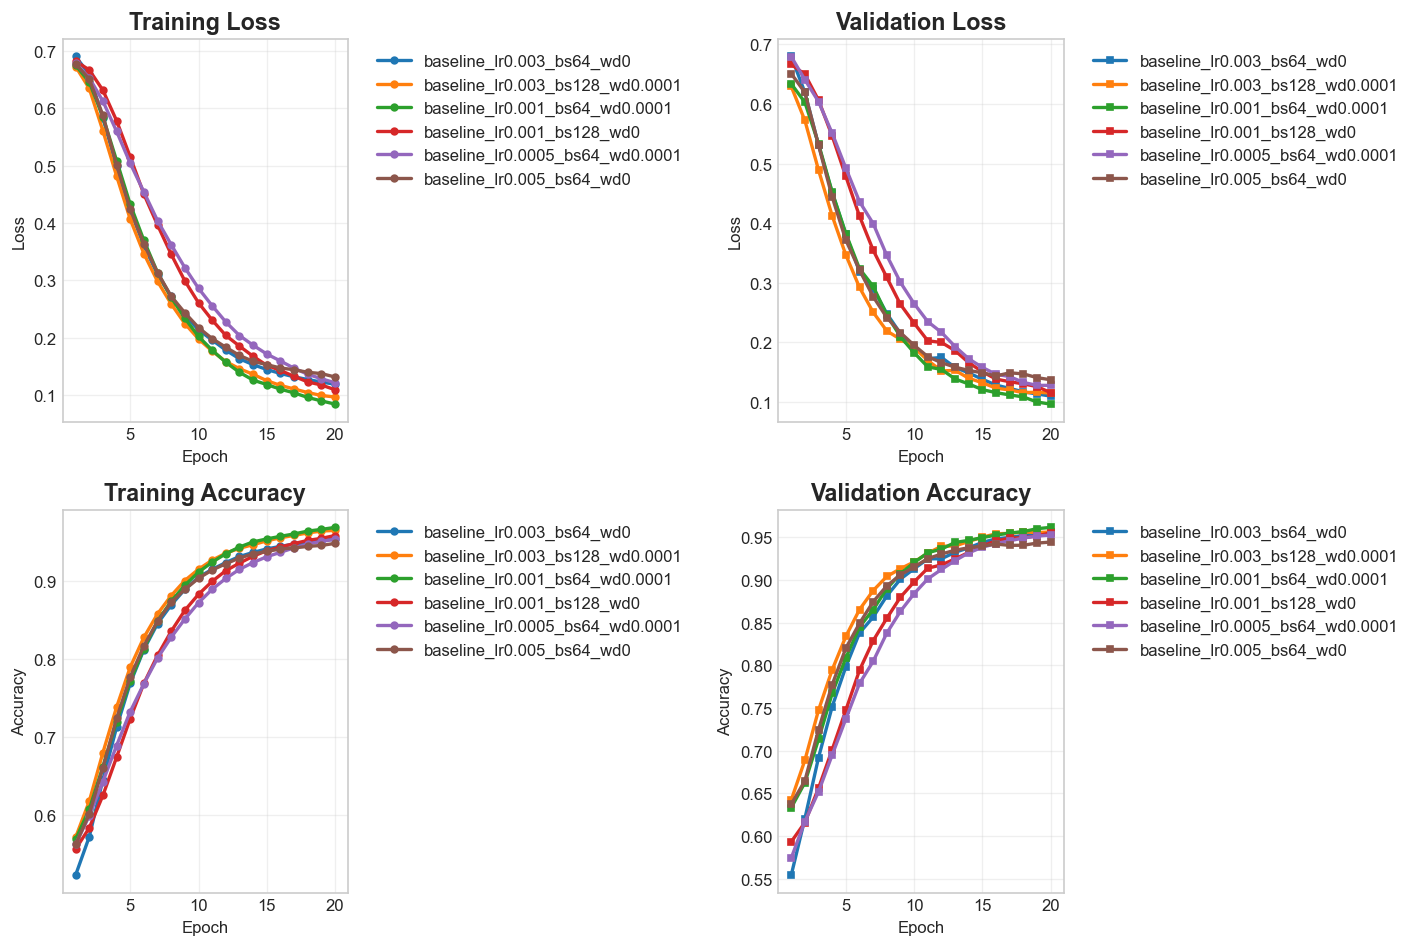

In [17]:
# --- Optional Longer Run: Baseline Training (15 epochs) ---
# Extended training to see full convergence patterns

training_config_long = config.get_training_config(quick=False)

print("📋 Longer Run Configuration:")
print(f"   Epochs: {training_config_long['epochs']}")
print(f"   Sweep ID: {training_config_long['sweep_id']}")
print(f"   Configurations: {len(training_config_long['sweep_grid'])} matched pairs")
print(f"   ⚠️  This will take significantly longer than the quick run")

history_df_long = run_sgd_sweep_with_progress(
    grid=training_config_long["sweep_grid"], 
    epochs=training_config_long["epochs"], 
    sweep_id=training_config_long["sweep_id"],
    device=DEVICE,
    make_model_fn=make_model,
    make_loaders_fn=make_loaders,
    num_workers=training_config_long["num_workers"],
    aug_flip=training_config_long["aug_flip"],
    aug_jitter=training_config_long["aug_jitter"],
    base_run_dir=training_config_long["base_run_dir"]
)

# Plot training curves for longer run
from src.notebooks import generate_timestamp
timestamp = generate_timestamp()
filename_long = f"{timestamp}_baseline_long_training_curves.png"
fig = plot_training_curves(history_df_long, save_path=filename_long)


## <a id="dp-sgd-training"></a>3.2. DP-SGD Training

Train with Differential Privacy SGD (DP-SGD) using AdamW optimizer with identical hyperparameter configurations as the baseline. The only difference is privacy-preserving mechanisms, enabling direct comparison of privacy-accuracy trade-offs.

**Matched pair design:** Every baseline configuration has an identical DP-SGD counterpart with the same hyperparameters, optimizer, model, and data. Performance differences are due solely to privacy mechanisms.

**Privacy configuration:**
- Same 6 configurations as baseline
- [Opacus PrivacyEngine](https://opacus.ai/api/privacy_engine/) with [RDP accounting](https://arxiv.org/abs/1702.07476)
  - Noise multiplier: 1.1 (moderate privacy, good accuracy balance)
  - Gradient clipping: max_grad_norm=1.0
  - Privacy budget: Tracks epsilon (ε) throughout training

**Understanding Epsilon (ε) Values You'll See:**

During training, you'll see epsilon values reported. Here's what they mean in practice:

- **ε < 1**: Very strong privacy (e.g., ε=0.5)
  - Used for highly sensitive data (medical records, financial data)
  - Strong protection against membership inference
  - May require more epochs or larger datasets for good accuracy

- **ε = 1-5**: Moderate privacy (e.g., ε=2.0)
  - Common for many real-world applications
  - Good balance between privacy and utility
  - Provides meaningful protection while maintaining reasonable accuracy

- **ε = 5-10**: Weaker privacy (e.g., ε=8.0)
  - May still provide some protection
  - Better accuracy, but privacy guarantees are weaker
  - Often used when privacy is less critical

- **ε > 10**: Very weak privacy
  - Little to no meaningful protection
  - Essentially equivalent to non-private training
  - Not recommended for sensitive data

**In this notebook:** With our configuration (noise_multiplier=1.1, 5-20 epochs), you'll typically see ε values in the range of 1-5, providing moderate privacy protection suitable for this educational demonstration. 📚 Learn more about epsilon interpretation: [Dwork & Roth Textbook - Chapter 3](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf)

**Training Options:**
You can run either the quick run, the long run, or both:
- **Quick (5 epochs)**: Fast demonstration of privacy-accuracy trade-offs
- **Long (20 epochs)**: Extended training (DP-SGD often needs more epochs than baseline for convergence)

**Note:** If you run both, the analysis cells will automatically use the long run data for consistency. The quick run is useful for quick exploration, while the long run provides better convergence patterns and more accurate privacy-accuracy trade-off analysis.

### <a id="quick-run-dp-sgd-training"></a>⚠️ 3.2.1. Quick Run: DP-SGD Training ⚠️

**This cell will run the quick DP-SGD training (5 epochs).**

This is a fast demonstration that trains for 5 epochs with differential privacy. If you want to see full convergence patterns, you can also run the long training cell below. If you run both, the analysis cells will automatically use the long run data.



In [19]:
# --- DP-SGD Training: Import Helper Modules ---
# Reuses shared training infrastructure from Cell 19 (DEVICE, make_loaders, make_model)
# This ensures both baseline and DP-SGD use identical setup for fair comparison

from src.training import (
    run_dp_sgd_sweep_with_progress,
    plot_training_curves
)

# Reuse shared infrastructure:
# - DEVICE, MEAN, STD from unified setup (Cell 19)
# - make_loaders() function from unified setup (Cell 19)
# - make_model() function from baseline section (Cell 20)


/opt/anaconda3/envs/dp-sgd-py312-env/lib/python3.12/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


📋 Quick Run Configuration:
   :
     Epochs: 5
     Sweep ID: eyeglasses_dp_sgd_v1_quick
     Configurations: 6 matched pairs (identical to baseline)
     Privacy (noise_multiplier): 0.5
     Privacy (max_grad_norm): 1.5
     Optimizer: AdamW (for fair comparison)

🔒 Starting DP-SGD Hyperparameter Sweep (6 runs)
📋 Sweep ID: eyeglasses_dp_sgd_v1_quick
🔐 Privacy params: noise_multiplier=0.5, max_grad_norm=1.5, delta=1e-05

📊 Run 1/6: dp_lr0.003_bs64_wd0_nm0.5
   Config: lr=0.003, bs=64, wd=0.0, noise_mult=0.5


Epoch 1/5:   0%|                                               | 0/250 [00:00<?]sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


✅ Completed: test_acc=0.6300, val_acc=0.6125, eps=8.79, time=189.9s

📈 Progress: 1/6 runs completed

📊 Run 2/6: dp_lr0.003_bs128_wd0.0001_nm0.5
   Config: lr=0.003, bs=128, wd=0.0001, noise_mult=0.5


✅ Completed: test_acc=0.6085, val_acc=0.6030, eps=11.21, time=170.6s

📈 Progress: 2/6 runs completed

📊 Run 3/6: dp_lr0.001_bs64_wd0.0001_nm0.5
   Config: lr=0.001, bs=64, wd=0.0001, noise_mult=0.5


✅ Completed: test_acc=0.5595, val_acc=0.5640, eps=8.79, time=175.7s

📈 Progress: 3/6 runs completed

📊 Run 4/6: dp_lr0.001_bs128_wd0_nm0.5
   Config: lr=0.001, bs=128, wd=0.0, noise_mult=0.5


✅ Completed: test_acc=0.5500, val_acc=0.5605, eps=11.21, time=136.6s

📈 Progress: 4/6 runs completed

📊 Run 5/6: dp_lr0.0005_bs64_wd0.0001_nm0.5
   Config: lr=0.0005, bs=64, wd=0.0001, noise_mult=0.5


✅ Completed: test_acc=0.5575, val_acc=0.5630, eps=8.79, time=176.1s

📈 Progress: 5/6 runs completed

📊 Run 6/6: dp_lr0.005_bs64_wd0_nm0.5
   Config: lr=0.005, bs=64, wd=0.0, noise_mult=0.5


✅ Completed: test_acc=0.6670, val_acc=0.6440, eps=8.79, time=174.8s

🏆 TRAINING RUNS COMPLETED
✅ Run 1: dp_lr0.003_bs64_wd0_nm0.5
   Test Acc: 0.6300 | Val Acc: 0.6125 | Time: 189.9s

✅ Run 2: dp_lr0.003_bs128_wd0.0001_nm0.5
   Test Acc: 0.6085 | Val Acc: 0.6030 | Time: 170.6s

✅ Run 3: dp_lr0.001_bs64_wd0.0001_nm0.5
   Test Acc: 0.5595 | Val Acc: 0.5640 | Time: 175.7s

✅ Run 4: dp_lr0.001_bs128_wd0_nm0.5
   Test Acc: 0.5500 | Val Acc: 0.5605 | Time: 136.6s

✅ Run 5: dp_lr0.0005_bs64_wd0.0001_nm0.5
   Test Acc: 0.5575 | Val Acc: 0.5630 | Time: 176.1s

🥇 Run 6: dp_lr0.005_bs64_wd0_nm0.5
   Test Acc: 0.6670 | Val Acc: 0.6440 | Time: 174.8s

🎯 Best Run: dp_lr0.005_bs64_wd0_nm0.5 (Test Acc: 0.6670)

💾 Saved Run Artifacts:
   📁 runs/dp_sgd/20251122_205728_dp_lr0.003_bs64_wd0_nm0.5_eyeglasses_dp_sgd_v1_quick
   📁 runs/dp_sgd/20251122_210019_dp_lr0.003_bs128_wd0.0001_nm0.5_eyeglasses_dp_sgd_v1_quick
   📁 runs/dp_sgd/20251122_210315_dp_lr0.001_bs64_wd0.0001_nm0.5_eyeglasses_dp_sgd_v1_quick
   

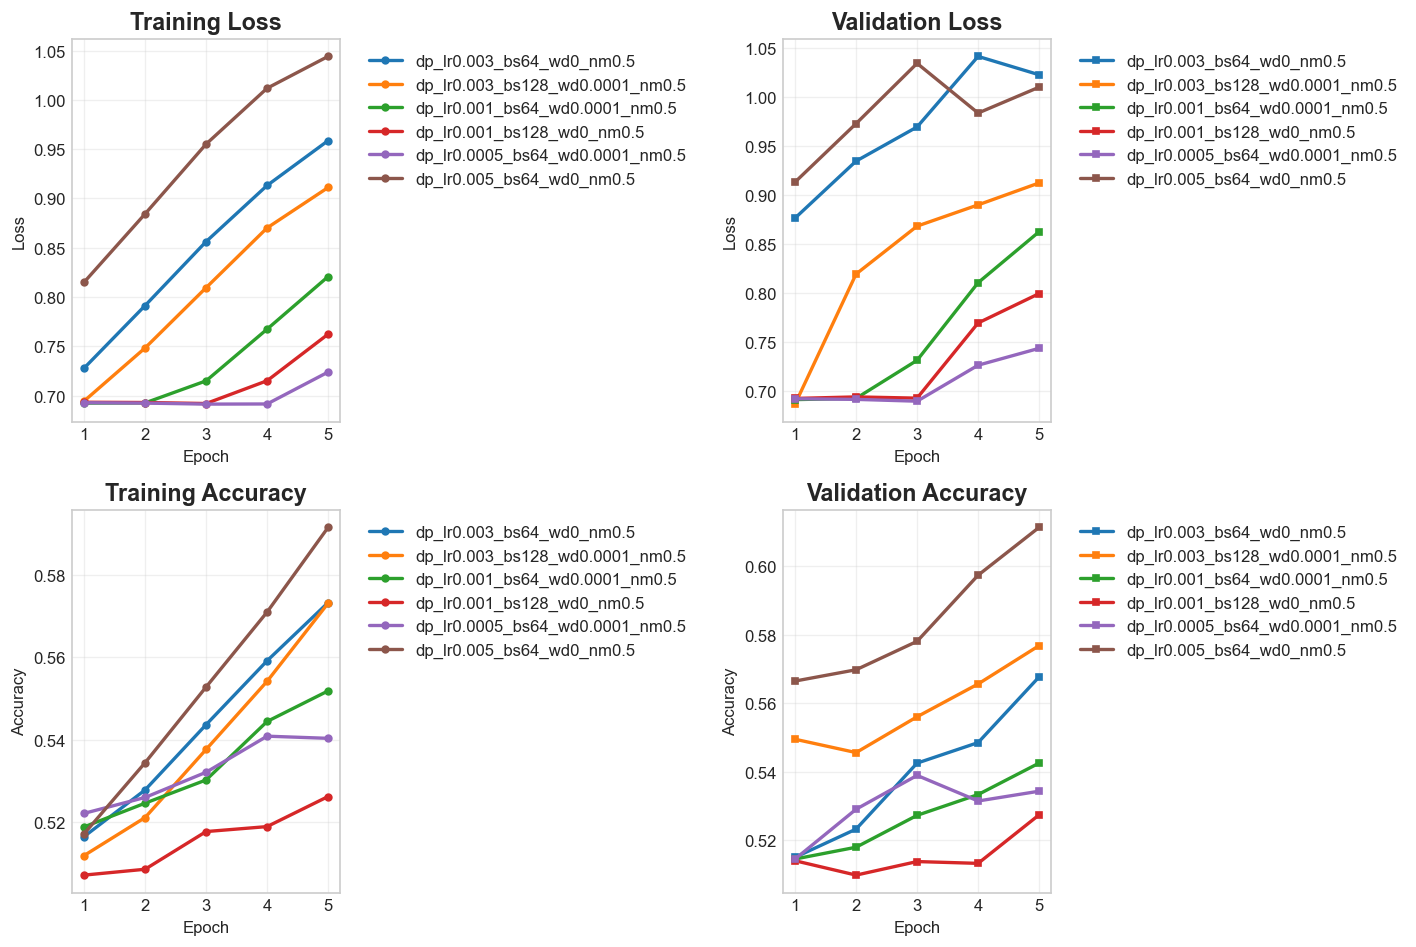

In [20]:
# --- Quick Run: DP-SGD Training (5 epochs) ---
# Fast demonstration with matched hyperparameter configurations (same as baseline).
# Uses Opacus PrivacyEngine with RDP accounting for differential privacy guarantees.
# Dependencies: config (from Cell 1), DEVICE (from Cell 19), make_model (from Cell 20), make_loaders (from Cell 19)

from src.notebooks import generate_timestamp, print_config

dp_sgd_config = config.get_dp_sgd_config(quick=True)

print("📋 Quick Run Configuration:")
print_config("", {
    "Epochs": dp_sgd_config['epochs'],
    "Sweep ID": dp_sgd_config['sweep_id'],
    "Configurations": f"{len(dp_sgd_config['sweep_grid'])} matched pairs (identical to baseline)",
    "Privacy (noise_multiplier)": dp_sgd_config['noise_multiplier'],
    "Privacy (max_grad_norm)": dp_sgd_config['max_grad_norm'],
    "Optimizer": "AdamW (for fair comparison)"
}, indent=3)

# Use the DP-SGD sweep function with centralized configuration
dp_history_df_quick = run_dp_sgd_sweep_with_progress(
    grid=dp_sgd_config["sweep_grid"],
    epochs=dp_sgd_config["epochs"],
    sweep_id=dp_sgd_config["sweep_id"],
    device=DEVICE,
    make_model_fn=make_model,
    make_loaders_fn=make_loaders,
    num_workers=dp_sgd_config["num_workers"],
    aug_flip=dp_sgd_config["aug_flip"],
    aug_jitter=dp_sgd_config["aug_jitter"],
    base_run_dir=dp_sgd_config["base_run_dir"],
    max_grad_norm=dp_sgd_config["max_grad_norm"],
    noise_multiplier=dp_sgd_config["noise_multiplier"],
    target_delta=dp_sgd_config["target_delta"]
)

# Plot training curves
timestamp = generate_timestamp()
filename_dp_quick = f"{timestamp}_dp_sgd_quick_training_curves.png"
fig = plot_training_curves(dp_history_df_quick, save_path=filename_dp_quick)


### <a id="long-run-dp-sgd-training"></a>⚠️ 3.2.2. Long Run: DP-SGD Training ⚠️ 

**This cell will run the long DP-SGD training (20 epochs).**

This extended training provides better convergence patterns and more accurate privacy-accuracy trade-off analysis. You can run this instead of or in addition to the quick run above. If you run both, the analysis cells will automatically use this long run data.



📋 Longer Run Configuration:
   Epochs: 20
   Sweep ID: eyeglasses_dp_sgd_v1_long
   Configurations: 6 matched pairs (identical to baseline)
   Privacy: noise_multiplier=0.5, max_grad_norm=1.5
   ⚠️  This will take significantly longer than the quick run

🔒 Starting DP-SGD Hyperparameter Sweep (6 runs)
📋 Sweep ID: eyeglasses_dp_sgd_v1_long
🔐 Privacy params: noise_multiplier=0.5, max_grad_norm=1.5, delta=1e-05

📊 Run 1/6: dp_lr0.003_bs64_wd0_nm0.5
   Config: lr=0.003, bs=64, wd=0.0, noise_mult=0.5


✅ Completed: test_acc=0.7465, val_acc=0.7390, eps=13.88, time=693.4s

📈 Progress: 1/6 runs completed

📊 Run 2/6: dp_lr0.003_bs128_wd0.0001_nm0.5
   Config: lr=0.003, bs=128, wd=0.0001, noise_mult=0.5


✅ Completed: test_acc=0.7380, val_acc=0.7180, eps=18.69, time=564.1s

📈 Progress: 2/6 runs completed

📊 Run 3/6: dp_lr0.001_bs64_wd0.0001_nm0.5
   Config: lr=0.001, bs=64, wd=0.0001, noise_mult=0.5


✅ Completed: test_acc=0.6310, val_acc=0.6300, eps=13.88, time=712.0s

📈 Progress: 3/6 runs completed

📊 Run 4/6: dp_lr0.001_bs128_wd0_nm0.5
   Config: lr=0.001, bs=128, wd=0.0, noise_mult=0.5


✅ Completed: test_acc=0.6240, val_acc=0.6145, eps=18.69, time=553.3s

📈 Progress: 4/6 runs completed

📊 Run 5/6: dp_lr0.0005_bs64_wd0.0001_nm0.5
   Config: lr=0.0005, bs=64, wd=0.0001, noise_mult=0.5


✅ Completed: test_acc=0.5755, val_acc=0.5885, eps=13.88, time=692.0s

📈 Progress: 5/6 runs completed

📊 Run 6/6: dp_lr0.005_bs64_wd0_nm0.5
   Config: lr=0.005, bs=64, wd=0.0, noise_mult=0.5


✅ Completed: test_acc=0.7590, val_acc=0.7395, eps=13.88, time=694.9s

🏆 TRAINING RUNS COMPLETED
✅ Run 1: dp_lr0.003_bs64_wd0_nm0.5
   Test Acc: 0.7465 | Val Acc: 0.7390 | Time: 693.4s

✅ Run 2: dp_lr0.003_bs128_wd0.0001_nm0.5
   Test Acc: 0.7380 | Val Acc: 0.7180 | Time: 564.1s

✅ Run 3: dp_lr0.001_bs64_wd0.0001_nm0.5
   Test Acc: 0.6310 | Val Acc: 0.6300 | Time: 712.0s

✅ Run 4: dp_lr0.001_bs128_wd0_nm0.5
   Test Acc: 0.6240 | Val Acc: 0.6145 | Time: 553.3s

✅ Run 5: dp_lr0.0005_bs64_wd0.0001_nm0.5
   Test Acc: 0.5755 | Val Acc: 0.5885 | Time: 692.0s

🥇 Run 6: dp_lr0.005_bs64_wd0_nm0.5
   Test Acc: 0.7590 | Val Acc: 0.7395 | Time: 694.9s

🎯 Best Run: dp_lr0.005_bs64_wd0_nm0.5 (Test Acc: 0.7590)

💾 Saved Run Artifacts:
   📁 runs/dp_sgd/20251122_212257_dp_lr0.003_bs64_wd0_nm0.5_eyeglasses_dp_sgd_v1_long
   📁 runs/dp_sgd/20251122_213221_dp_lr0.003_bs128_wd0.0001_nm0.5_eyeglasses_dp_sgd_v1_long
   📁 runs/dp_sgd/20251122_214413_dp_lr0.001_bs64_wd0.0001_nm0.5_eyeglasses_dp_sgd_v1_long
   📁 

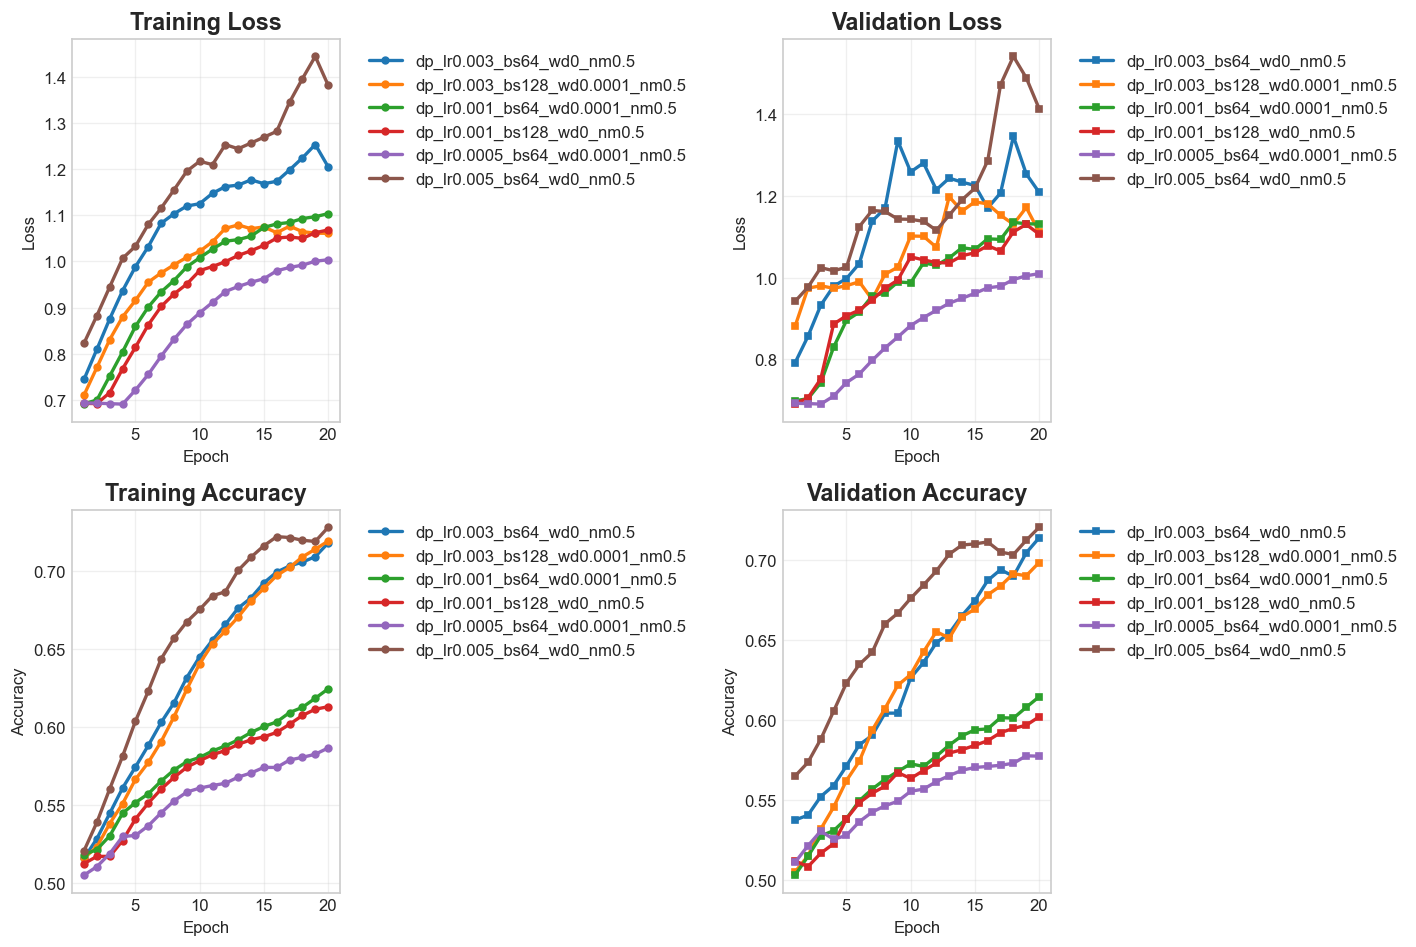

In [21]:
# --- Optional Longer Run: DP-SGD Training (20 epochs) ---

dp_sgd_config_long = config.get_dp_sgd_config(quick=False)

print("📋 Longer Run Configuration:")
print(f"   Epochs: {dp_sgd_config_long['epochs']}")
print(f"   Sweep ID: {dp_sgd_config_long['sweep_id']}")
print(f"   Configurations: {len(dp_sgd_config_long['sweep_grid'])} matched pairs (identical to baseline)")
print(f"   Privacy: noise_multiplier={dp_sgd_config_long['noise_multiplier']}, max_grad_norm={dp_sgd_config_long['max_grad_norm']}")
print(f"   ⚠️  This will take significantly longer than the quick run")

dp_history_df_long = run_dp_sgd_sweep_with_progress(
    grid=dp_sgd_config_long["sweep_grid"],
    epochs=dp_sgd_config_long["epochs"],
    sweep_id=dp_sgd_config_long["sweep_id"],
    device=DEVICE,
    make_model_fn=make_model,
    make_loaders_fn=make_loaders,
    num_workers=dp_sgd_config_long["num_workers"],
    aug_flip=dp_sgd_config_long["aug_flip"],
    aug_jitter=dp_sgd_config_long["aug_jitter"],
    base_run_dir=dp_sgd_config_long["base_run_dir"],
    max_grad_norm=dp_sgd_config_long["max_grad_norm"],
    noise_multiplier=dp_sgd_config_long["noise_multiplier"],
    target_delta=dp_sgd_config_long["target_delta"]
)

# Plot training curves for longer run
from src.notebooks import generate_timestamp
timestamp = generate_timestamp()
filename_dp_long = f"{timestamp}_dp_sgd_long_training_curves.png"
fig = plot_training_curves(dp_history_df_long, save_path=filename_dp_long)


# <a id="analysis"></a>5. Analysis

This section analyzes and compares the baseline and DP-SGD training results to quantify the **privacy-accuracy trade-off**.

**What's coming up:**
- **Matched Pair Analysis**: Direct comparison of baseline vs DP-SGD for identical configurations
- **Training Dynamics**: Visual comparison of convergence patterns and training behavior
- **Privacy-Accuracy Trade-off**: Visualization of how epsilon (privacy) relates to accuracy

**Why this matters:**
These analyses quantify the **privacy cost**—how much accuracy we sacrifice for privacy protection. This helps you understand the practical implications of using DP-SGD and make informed decisions about privacy-utility trade-offs.


## <a id="matched-pair-analysis"></a>5.1. Matched Pair Analysis

Compare baseline and DP-SGD training using **identical hyperparameters** to isolate the privacy-accuracy trade-off. Each baseline configuration has a corresponding DP-SGD configuration with the same learning rate, batch size, and weight decay.

**What you'll see:**
- Side-by-side training curves and accuracy comparisons
- Privacy cost: accuracy differences between baseline and DP-SGD
- Epsilon (ε) values: privacy budget consumed for each configuration

**Key insight:** By controlling all variables except privacy mechanisms, we directly measure how much accuracy we sacrifice for privacy protection.


✅ Found training histories:
   • Quick pair: 30 baseline records, 30 DP-SGD records
   • Long pair: 120 baseline records, 120 DP-SGD records
   ℹ️  Both quick and long pairs detected. Generating plots for both...

📊 Generating matched pair comparison for QUICK runs...
📊 Matched pair comparison saved to: 20251122_221635_matched_pair_comparison_quick.png


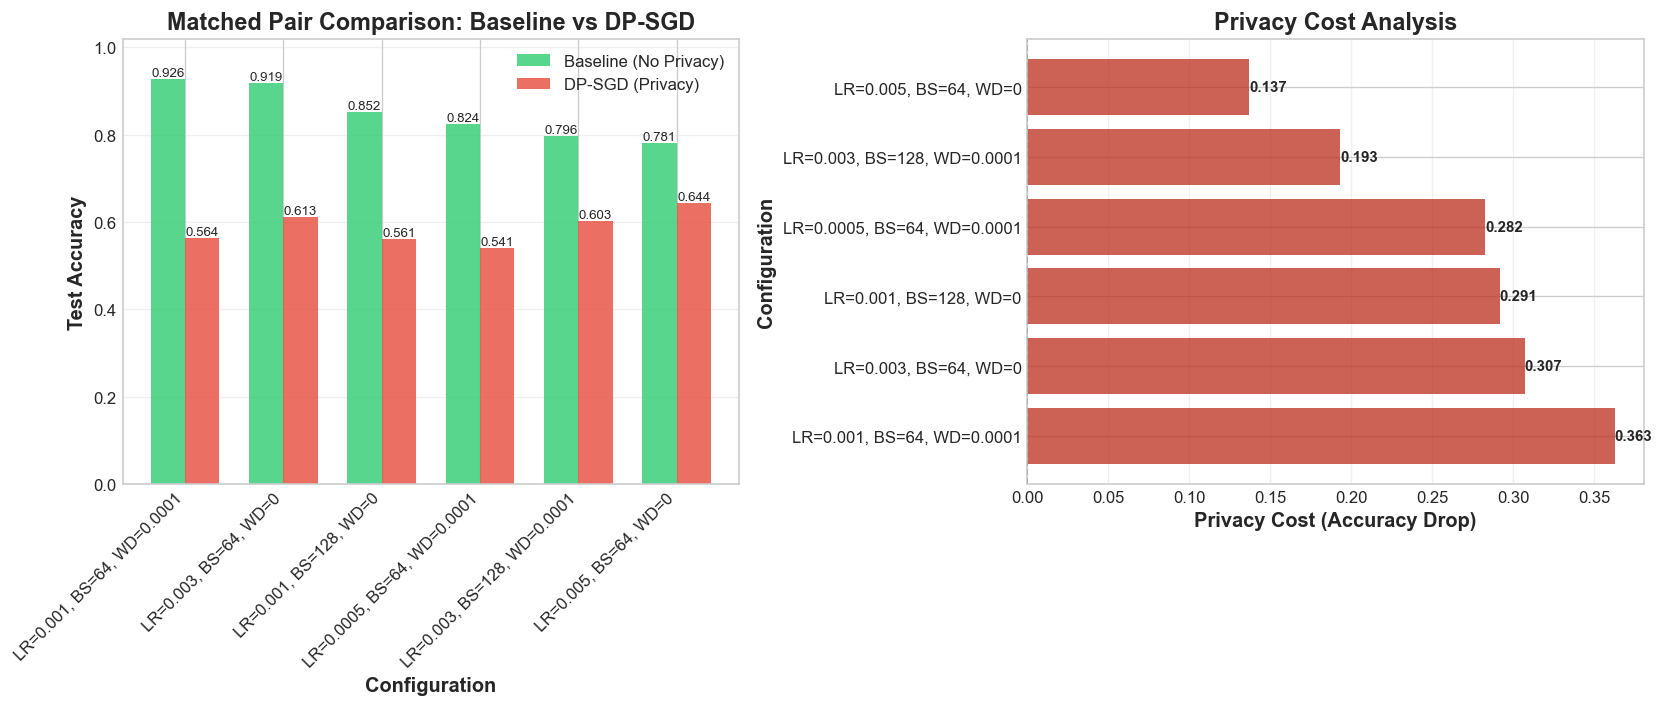

✅ Quick run comparison plot saved: 20251122_221635_matched_pair_comparison_quick.png

📊 Generating matched pair comparison for LONG runs...
📊 Matched pair comparison saved to: 20251122_221635_matched_pair_comparison_long.png


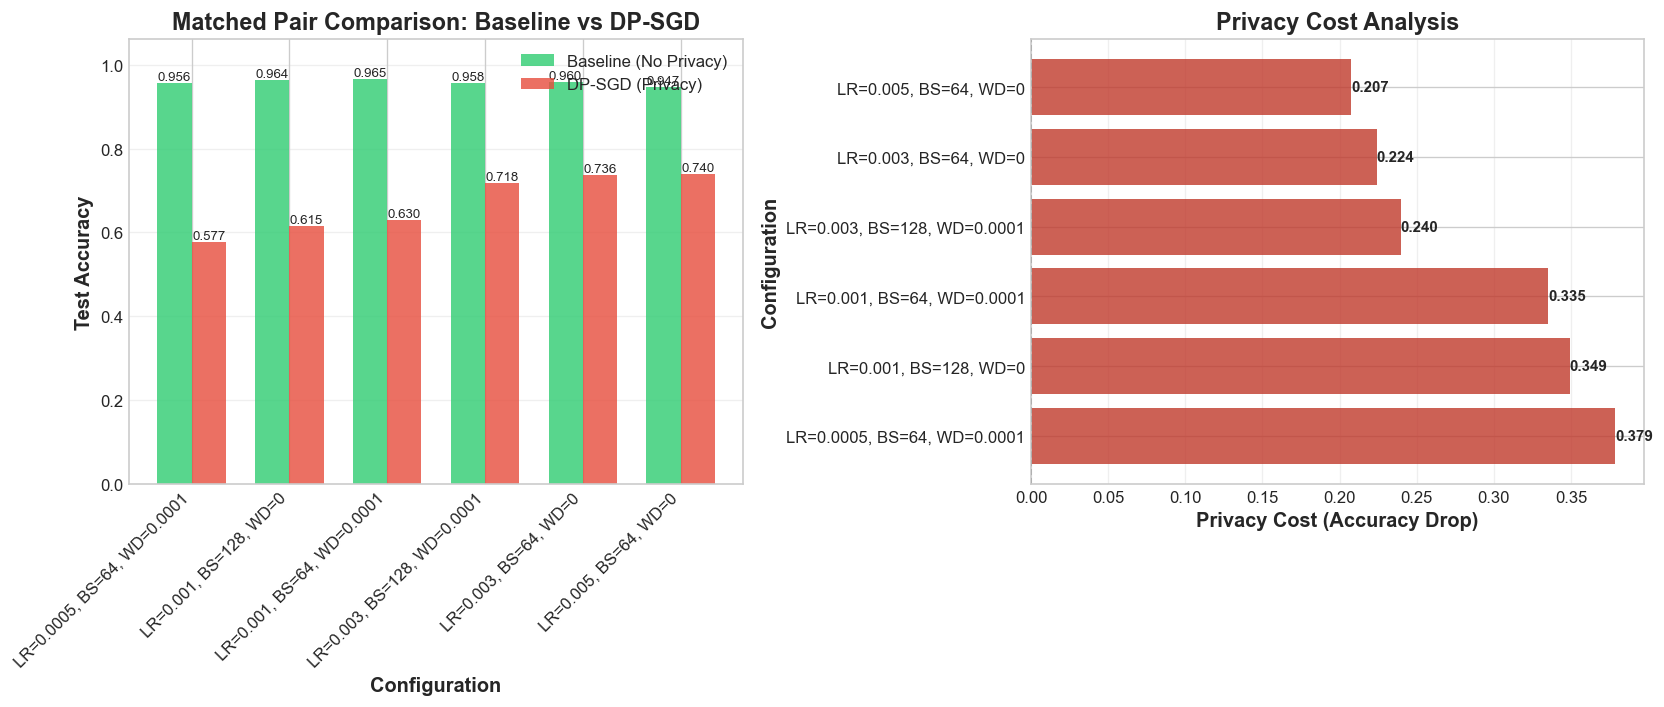

✅ Long run comparison plot saved: 20251122_221635_matched_pair_comparison_long.png


In [22]:
# --- Matched Pair Comparison
#   Quick: history_df_quick (from Cell 21), dp_history_df_quick (from Cell 25)
#   Long: history_df_long (from Cell 22), dp_history_df_long (from Cell 26)

from src.training import (
    plot_matched_pair_comparison,
    plot_privacy_cost_summary
)
from src.notebooks import generate_timestamp

# Check for both quick and long training histories
has_long_baseline = 'history_df_long' in globals()
has_long_dp = 'dp_history_df_long' in globals()
has_quick_baseline = 'history_df_quick' in globals()
has_quick_dp = 'dp_history_df_quick' in globals()

# Determine which pairs are available
has_quick_pair = has_quick_baseline and has_quick_dp
has_long_pair = has_long_baseline and has_long_dp

# Validate that we have at least one complete pair
if not has_quick_pair and not has_long_pair:
    missing = []
    if not has_quick_baseline and not has_long_baseline:
        missing.append("baseline training history")
    if not has_quick_dp and not has_long_dp:
        missing.append("DP-SGD training history")
    
    print("❌ Missing required training histories. Please run the following cells first:")
    print()
    if not has_quick_baseline and not has_long_baseline:
        print("   • Quick Run Baseline Training (Cell 21) → creates 'history_df_quick'")
        print("   • Long Run Baseline Training (Cell 22) → creates 'history_df_long'")
    if not has_quick_dp and not has_long_dp:
        print("   • Quick Run DP-SGD Training (Cell 25) → creates 'dp_history_df_quick'")
        print("   • Long Run DP-SGD Training (Cell 26) → creates 'dp_history_df_long'")
    print()
    print("   After running those cells, return here to perform the matched pair analysis.")
    raise RuntimeError(f"Missing required variables: {', '.join(missing)}")

# Set baseline_history and dp_history for backward compatibility (prefer long if available)
if has_long_baseline:
    baseline_history = history_df_long
    baseline_type = "long"
elif has_quick_baseline:
    baseline_history = history_df_quick
    baseline_type = "quick"
else:
    baseline_history = None
    baseline_type = None

if has_long_dp:
    dp_history = dp_history_df_long
    dp_type = "long"
elif has_quick_dp:
    dp_history = dp_history_df_quick
    dp_type = "quick"
else:
    dp_history = None
    dp_type = None

# Display what we found
print("✅ Found training histories:")
if has_quick_pair:
    print(f"   • Quick pair: {len(history_df_quick)} baseline records, {len(dp_history_df_quick)} DP-SGD records")
if has_long_pair:
    print(f"   • Long pair: {len(history_df_long)} baseline records, {len(dp_history_df_long)} DP-SGD records")
if has_quick_pair and has_long_pair:
    print("   ℹ️  Both quick and long pairs detected. Generating plots for both...")
elif has_quick_pair:
    print("   ℹ️  Using quick run data for matched pair analysis.")
elif has_long_pair:
    print("   ℹ️  Using long run data for matched pair analysis.")

# Generate plots for all available pairs
timestamp = generate_timestamp()

if has_quick_pair:
    print("\n📊 Generating matched pair comparison for QUICK runs...")
    filename_quick = f"{timestamp}_matched_pair_comparison_quick.png"
    fig_quick = plot_matched_pair_comparison(
        baseline_history=history_df_quick,
        dp_history=dp_history_df_quick,
        save_path=filename_quick
    )
    print(f"✅ Quick run comparison plot saved: {filename_quick}")

if has_long_pair:
    print("\n📊 Generating matched pair comparison for LONG runs...")
    filename_long = f"{timestamp}_matched_pair_comparison_long.png"
    fig_long = plot_matched_pair_comparison(
        baseline_history=history_df_long,
        dp_history=dp_history_df_long,
        save_path=filename_long
    )
    print(f"✅ Long run comparison plot saved: {filename_long}")

# Also set default variables for backward compatibility with later cells
# (These will be used by subsequent cells that reference baseline_history and dp_history)
if baseline_history is None or dp_history is None:
    # If we don't have a matched pair for the default, use what we have
    if baseline_history is None and has_quick_baseline:
        baseline_history = history_df_quick
        baseline_type = "quick"
    if dp_history is None and has_quick_dp:
        dp_history = dp_history_df_quick
        dp_type = "quick"


✅ Generating privacy cost summaries:
   • Quick pair: 30 baseline records, 30 DP-SGD records
   • Long pair: 120 baseline records, 120 DP-SGD records
   ℹ️  Both quick and long pairs detected. Generating summaries for both...

📊 Generating privacy cost summary for QUICK runs...

📊 MATCHED PAIR ANALYSIS: Privacy Cost Summary
Configuration                  Baseline Acc    DP-SGD Acc      Cost         Epsilon   
--------------------------------------------------------------------------------
LR=0.001, BS=64, WD=0.0001     0.9265          0.5640          0.3625       8.79      
LR=0.003, BS=64, WD=0          0.9195          0.6125          0.3070       8.79      
LR=0.001, BS=128, WD=0         0.8520          0.5605          0.2915       11.21     
LR=0.0005, BS=64, WD=0.0001    0.8235          0.5410          0.2825       8.79      
LR=0.003, BS=128, WD=0.0001    0.7960          0.6030          0.1930       11.21     
LR=0.005, BS=64, WD=0          0.7810          0.6440          0.1370  

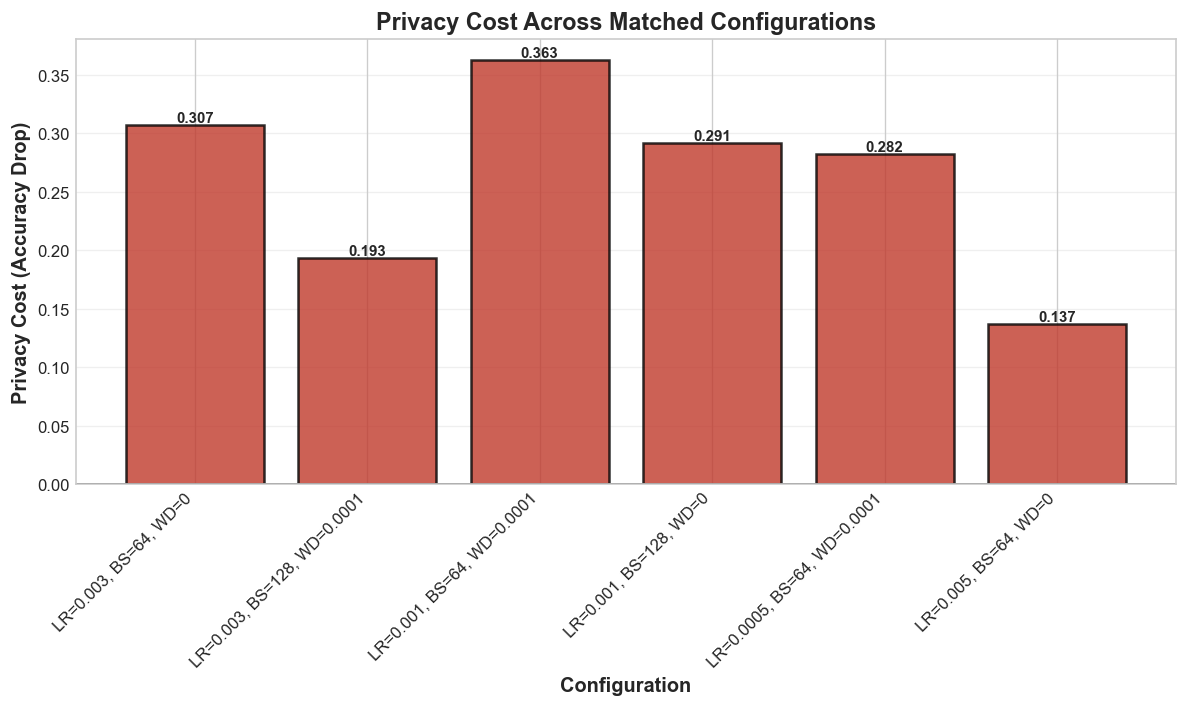

✅ Quick run privacy cost summary saved: 20251122_221635_privacy_cost_summary_quick.png

📊 Generating privacy cost summary for LONG runs...

📊 MATCHED PAIR ANALYSIS: Privacy Cost Summary
Configuration                  Baseline Acc    DP-SGD Acc      Cost         Epsilon   
--------------------------------------------------------------------------------
LR=0.0005, BS=64, WD=0.0001    0.9555          0.5770          0.3785       13.88     
LR=0.001, BS=128, WD=0         0.9635          0.6145          0.3490       18.69     
LR=0.001, BS=64, WD=0.0001     0.9650          0.6300          0.3350       13.88     
LR=0.003, BS=128, WD=0.0001    0.9575          0.7180          0.2395       18.69     
LR=0.003, BS=64, WD=0          0.9600          0.7360          0.2240       13.88     
LR=0.005, BS=64, WD=0          0.9470          0.7395          0.2075       13.88     
Average Privacy Cost: 0.2889
Max Privacy Cost: 0.3785
Min Privacy Cost: 0.2075

📊 Privacy cost summary saved to: 20251122_22

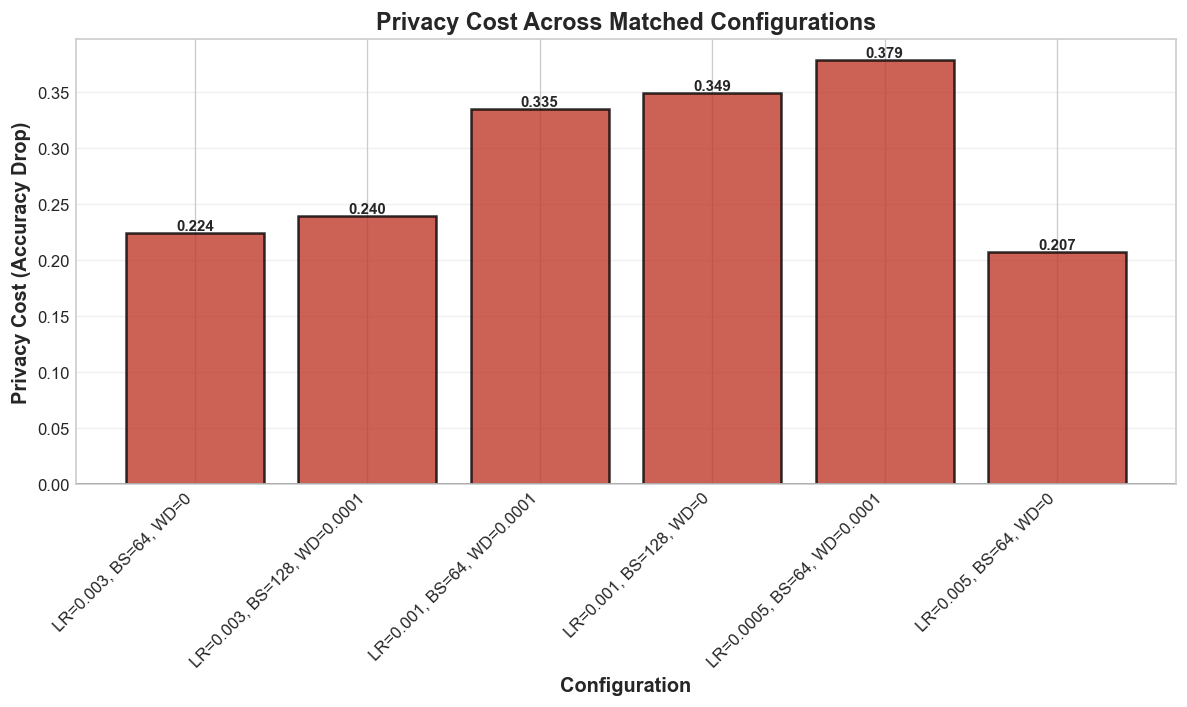

✅ Long run privacy cost summary saved: 20251122_221635_privacy_cost_summary_long.png


In [23]:
# --- Privacy Cost Summary: Detailed Analysis with Epsilon Values ---
# Creates a summary table and visualization showing privacy costs across all configurations.
# Shows accuracy differences and epsilon (ε) privacy budget consumption.
# Dependencies: baseline_history, dp_history (set by previous cell - supports both quick and long runs)

from src.training import plot_privacy_cost_summary
from src.notebooks import generate_timestamp

# Check for both quick and long training histories
has_long_baseline = 'history_df_long' in globals()
has_long_dp = 'dp_history_df_long' in globals()
has_quick_baseline = 'history_df_quick' in globals()
has_quick_dp = 'dp_history_df_quick' in globals()

# Determine which pairs are available
has_quick_pair = has_quick_baseline and has_quick_dp
has_long_pair = has_long_baseline and has_long_dp

# Validate that we have at least one complete pair
if not has_quick_pair and not has_long_pair:
    print("❌ Missing required training histories. Please run the training cells first.")
    print("   You need at least one complete pair (baseline + DP-SGD) from either:")
    print("   • Quick Run Baseline Training (Cell 21) + Quick Run DP-SGD Training (Cell 25)")
    print("   • Long Run Baseline Training (Cell 22) + Long Run DP-SGD Training (Cell 26)")
    raise RuntimeError("Missing required training histories")

# Display what we found
print("✅ Generating privacy cost summaries:")
if has_quick_pair:
    print(f"   • Quick pair: {len(history_df_quick)} baseline records, {len(dp_history_df_quick)} DP-SGD records")
if has_long_pair:
    print(f"   • Long pair: {len(history_df_long)} baseline records, {len(dp_history_df_long)} DP-SGD records")
if has_quick_pair and has_long_pair:
    print("   ℹ️  Both quick and long pairs detected. Generating summaries for both...")
elif has_quick_pair:
    print("   ℹ️  Using quick run data for privacy cost summary.")
elif has_long_pair:
    print("   ℹ️  Using long run data for privacy cost summary.")

# Generate summaries for all available pairs
timestamp = generate_timestamp()

if has_quick_pair:
    print("\n📊 Generating privacy cost summary for QUICK runs...")
    filename_quick = f"{timestamp}_privacy_cost_summary_quick.png"
    fig_quick = plot_privacy_cost_summary(
        baseline_history=history_df_quick,
        dp_history=dp_history_df_quick,
        save_path=filename_quick
    )
    print(f"✅ Quick run privacy cost summary saved: {filename_quick}")

if has_long_pair:
    print("\n📊 Generating privacy cost summary for LONG runs...")
    filename_long = f"{timestamp}_privacy_cost_summary_long.png"
    fig_long = plot_privacy_cost_summary(
        baseline_history=history_df_long,
        dp_history=dp_history_df_long,
        save_path=filename_long
    )
    print(f"✅ Long run privacy cost summary saved: {filename_long}")


## <a id="training-dynamics-comparison"></a>5.2. Training Dynamics Comparison

Visualize how DP-SGD affects training dynamics compared to baseline. This shows:
- Slower convergence due to noise in gradients
- Lower final accuracy (privacy cost)
- Training behavior differences for matched configurations


✅ Generating training dynamics comparisons:
   • Quick pair: 30 baseline records, 30 DP-SGD records
   • Long pair: 120 baseline records, 120 DP-SGD records
   ℹ️  Both quick and long pairs detected. Generating comparisons for both...

📊 Generating training dynamics comparison for QUICK runs (top 3 configs)...
📊 Training dynamics comparison saved to: 20251122_221637_training_dynamics_comparison_quick.png


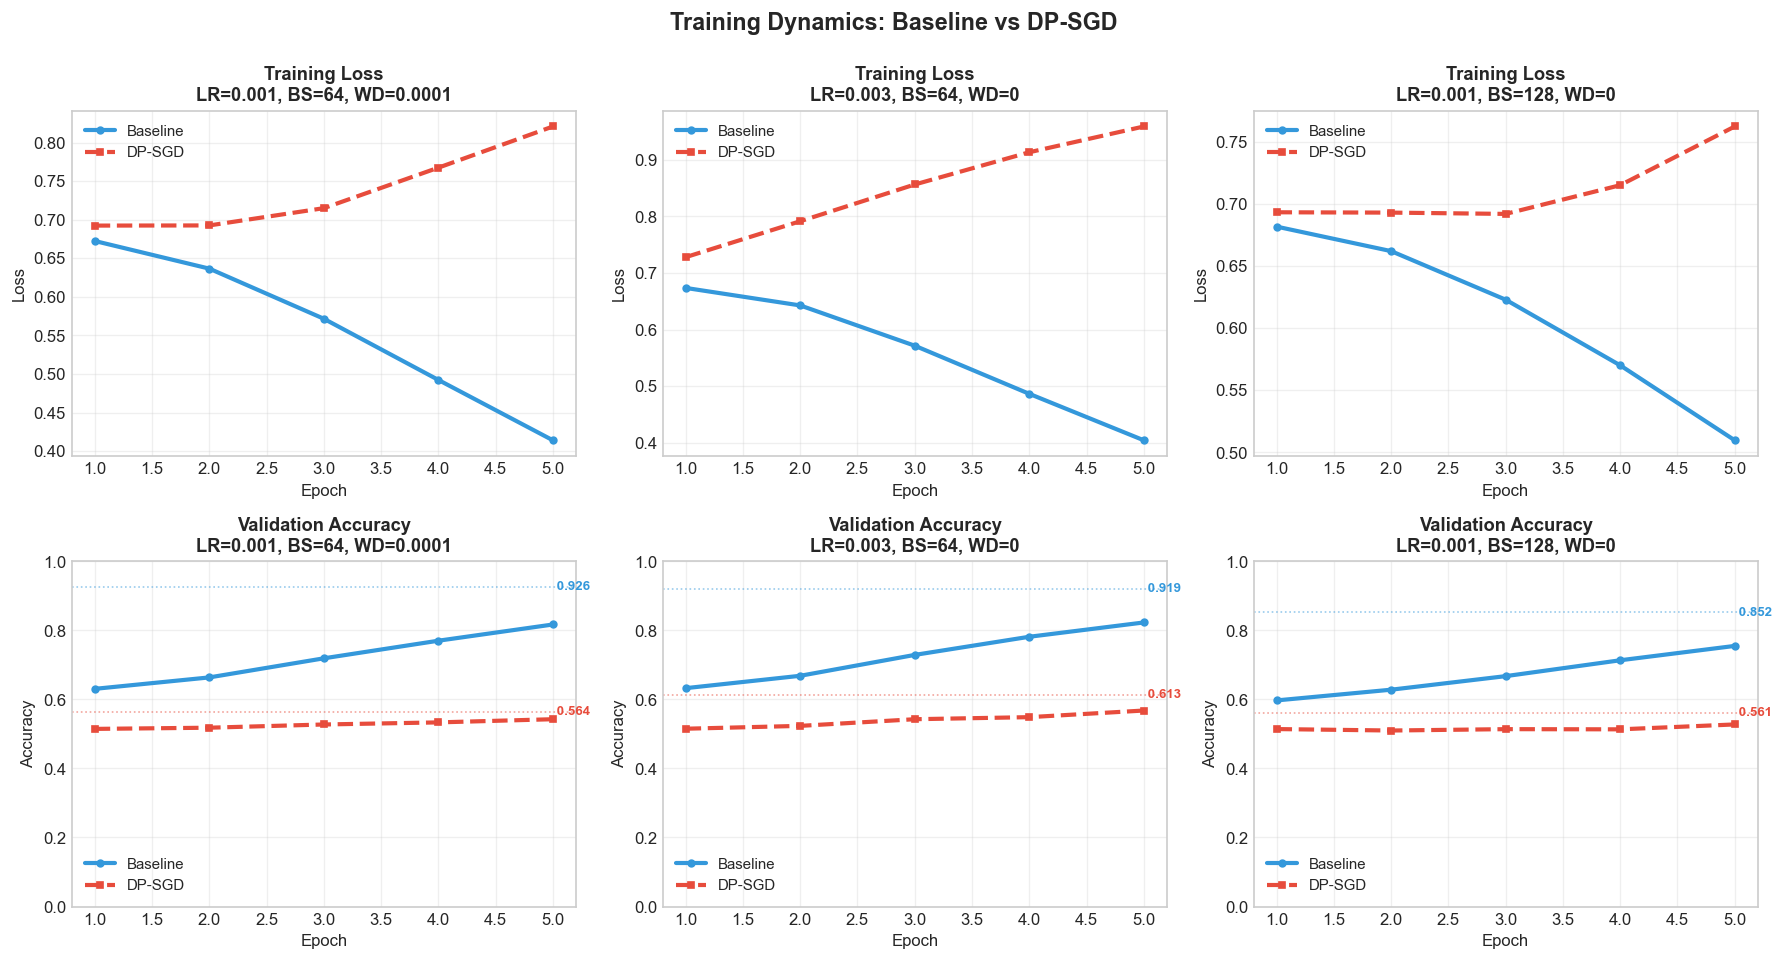

✅ Quick run training dynamics comparison saved: 20251122_221637_training_dynamics_comparison_quick.png

📊 Generating training dynamics comparison for LONG runs (top 3 configs)...
📊 Training dynamics comparison saved to: 20251122_221637_training_dynamics_comparison_long.png


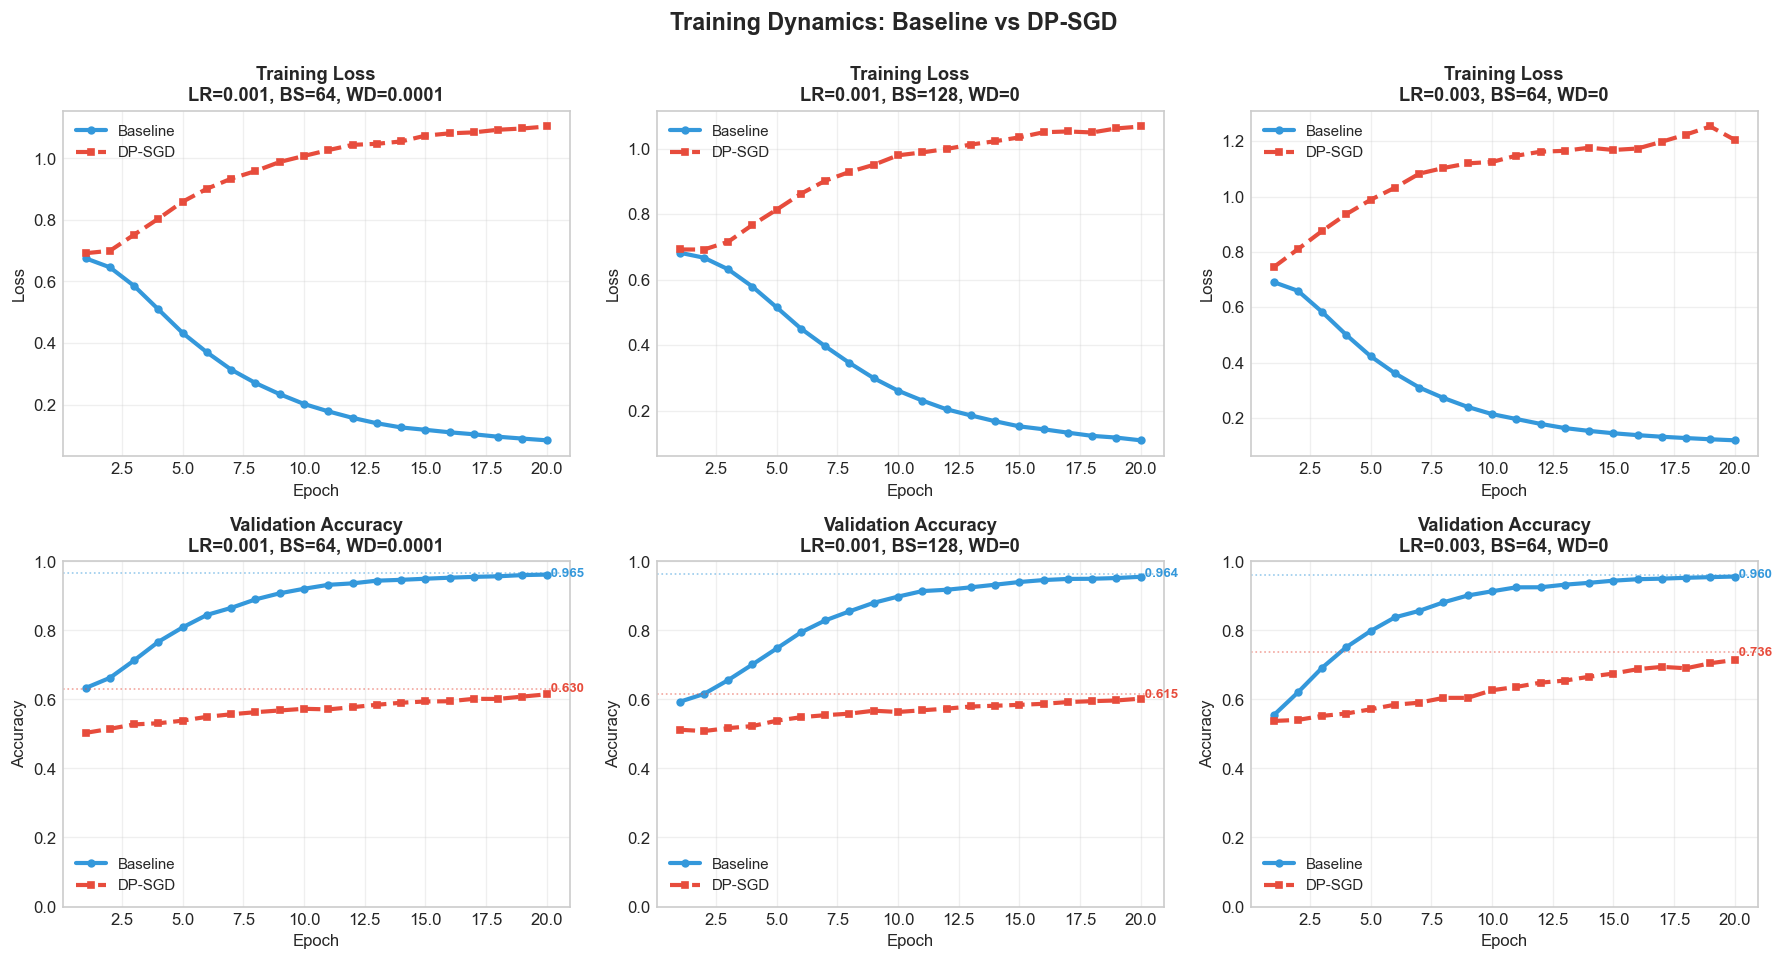

✅ Long run training dynamics comparison saved: 20251122_221637_training_dynamics_comparison_long.png


In [24]:
# --- Training Dynamics Comparison: Baseline vs DP-SGD ---
# Visualizes how DP-SGD affects training dynamics compared to baseline.
# Shows slower convergence and lower final accuracy (privacy cost) for matched configurations.
# Dependencies: baseline_history, dp_history (set by previous cell - supports both quick and long runs)

from src.training import plot_training_dynamics_comparison
from src.notebooks import generate_timestamp

# Configuration: number of top configurations to display
MAX_CONFIGS_TO_DISPLAY = 3  # Show top configurations by baseline accuracy

# Check for both quick and long training histories
has_long_baseline = 'history_df_long' in globals()
has_long_dp = 'dp_history_df_long' in globals()
has_quick_baseline = 'history_df_quick' in globals()
has_quick_dp = 'dp_history_df_quick' in globals()

# Determine which pairs are available
has_quick_pair = has_quick_baseline and has_quick_dp
has_long_pair = has_long_baseline and has_long_dp

# Validate that we have at least one complete pair
if not has_quick_pair and not has_long_pair:
    print("❌ Missing required training histories. Please run the training cells first.")
    print("   You need at least one complete pair (baseline + DP-SGD) from either:")
    print("   • Quick Run Baseline Training (Cell 21) + Quick Run DP-SGD Training (Cell 25)")
    print("   • Long Run Baseline Training (Cell 22) + Long Run DP-SGD Training (Cell 26)")
    raise RuntimeError("Missing required training histories")

# Display what we found
print("✅ Generating training dynamics comparisons:")
if has_quick_pair:
    print(f"   • Quick pair: {len(history_df_quick)} baseline records, {len(dp_history_df_quick)} DP-SGD records")
if has_long_pair:
    print(f"   • Long pair: {len(history_df_long)} baseline records, {len(dp_history_df_long)} DP-SGD records")
if has_quick_pair and has_long_pair:
    print("   ℹ️  Both quick and long pairs detected. Generating comparisons for both...")
elif has_quick_pair:
    print("   ℹ️  Using quick run data for training dynamics comparison.")
elif has_long_pair:
    print("   ℹ️  Using long run data for training dynamics comparison.")

# Generate comparisons for all available pairs
timestamp = generate_timestamp()

if has_quick_pair:
    print(f"\n📊 Generating training dynamics comparison for QUICK runs (top {MAX_CONFIGS_TO_DISPLAY} configs)...")
    filename_quick = f"{timestamp}_training_dynamics_comparison_quick.png"
    fig_quick = plot_training_dynamics_comparison(
        baseline_history=history_df_quick,
        dp_history=dp_history_df_quick,
        save_path=filename_quick,
        max_configs=MAX_CONFIGS_TO_DISPLAY
    )
    print(f"✅ Quick run training dynamics comparison saved: {filename_quick}")

if has_long_pair:
    print(f"\n📊 Generating training dynamics comparison for LONG runs (top {MAX_CONFIGS_TO_DISPLAY} configs)...")
    filename_long = f"{timestamp}_training_dynamics_comparison_long.png"
    fig_long = plot_training_dynamics_comparison(
        baseline_history=history_df_long,
        dp_history=dp_history_df_long,
        save_path=filename_long,
        max_configs=MAX_CONFIGS_TO_DISPLAY
    )
    print(f"✅ Long run training dynamics comparison saved: {filename_long}")


## <a id="privacy-accuracy-trade-off"></a>5.3. Privacy-Accuracy Trade-off

Visualize the fundamental DP-SGD trade-off: stronger privacy (lower epsilon) typically comes at the cost of lower accuracy. Each point represents a matched configuration.

**What to Look For:**
- **Lower ε (left side)**: Stronger privacy, but typically lower accuracy
- **Higher ε (right side)**: Weaker privacy, but typically higher accuracy
- **Ideal configurations**: Points in the upper-left region (high accuracy with low epsilon)
- **Trade-off curve**: The general trend showing how accuracy decreases as privacy increases

**Interpreting the Results:**
- If all points cluster in the ε=1-5 range with good accuracy, you've achieved a good privacy-utility balance
- If accuracy drops significantly even with moderate ε, you may need to adjust privacy parameters or use more training data
- Remember: ε < 1 provides very strong privacy but may require more data/epochs for good accuracy


✅ Generating privacy-accuracy trade-off visualizations:
   • Quick pair: 30 baseline records, 30 DP-SGD records
   • Long pair: 120 baseline records, 120 DP-SGD records
   ℹ️  Both quick and long pairs detected. Generating trade-off plots for both...

📊 Generating privacy-accuracy trade-off plot for QUICK runs...
📊 Privacy-accuracy trade-off plot saved to: 20251122_222945_privacy_accuracy_tradeoff_quick.png


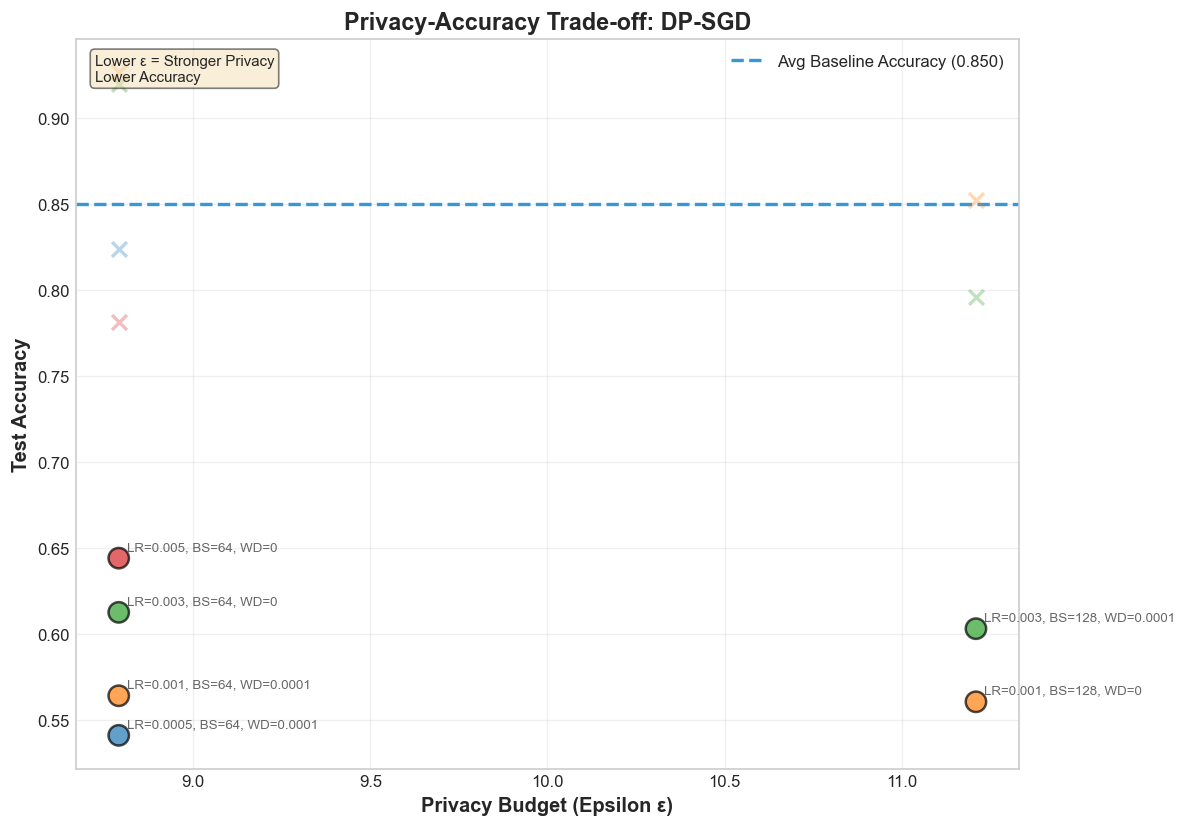

✅ Quick run privacy-accuracy trade-off plot saved: 20251122_222945_privacy_accuracy_tradeoff_quick.png

📊 Generating privacy-accuracy trade-off plot for LONG runs...
📊 Privacy-accuracy trade-off plot saved to: 20251122_222945_privacy_accuracy_tradeoff_long.png


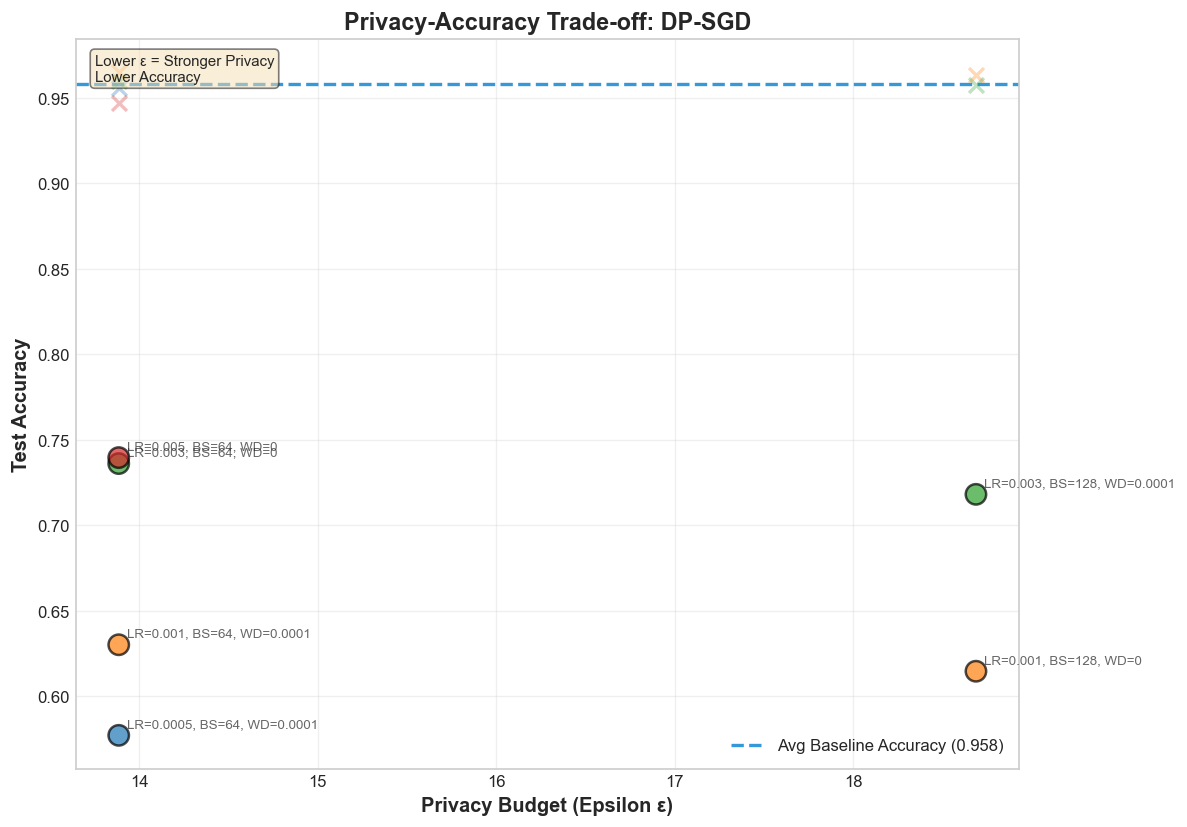

✅ Long run privacy-accuracy trade-off plot saved: 20251122_222945_privacy_accuracy_tradeoff_long.png


In [28]:
# --- Privacy-Accuracy Trade-off Visualization ---
# Visualizes the fundamental DP-SGD trade-off: stronger privacy (lower epsilon) typically
# comes at the cost of lower accuracy. Each point represents a matched configuration.
# Dependencies: baseline_history, dp_history (set by previous cell - supports both quick and long runs)

from src.training import plot_privacy_accuracy_tradeoff
from src.notebooks import generate_timestamp

# Check for both quick and long training histories
has_long_baseline = 'history_df_long' in globals()
has_long_dp = 'dp_history_df_long' in globals()
has_quick_baseline = 'history_df_quick' in globals()
has_quick_dp = 'dp_history_df_quick' in globals()

# Determine which pairs are available
has_quick_pair = has_quick_baseline and has_quick_dp
has_long_pair = has_long_baseline and has_long_dp

# Validate that we have at least one complete pair
if not has_quick_pair and not has_long_pair:
    print("❌ Missing required training histories. Please run the training cells first.")
    print("   You need at least one complete pair (baseline + DP-SGD) from either:")
    print("   • Quick Run Baseline Training (Cell 21) + Quick Run DP-SGD Training (Cell 25)")
    print("   • Long Run Baseline Training (Cell 22) + Long Run DP-SGD Training (Cell 26)")
    raise RuntimeError("Missing required training histories")

# Display what we found
print("✅ Generating privacy-accuracy trade-off visualizations:")
if has_quick_pair:
    print(f"   • Quick pair: {len(history_df_quick)} baseline records, {len(dp_history_df_quick)} DP-SGD records")
if has_long_pair:
    print(f"   • Long pair: {len(history_df_long)} baseline records, {len(dp_history_df_long)} DP-SGD records")
if has_quick_pair and has_long_pair:
    print("   ℹ️  Both quick and long pairs detected. Generating trade-off plots for both...")
elif has_quick_pair:
    print("   ℹ️  Using quick run data for privacy-accuracy trade-off visualization.")
elif has_long_pair:
    print("   ℹ️  Using long run data for privacy-accuracy trade-off visualization.")

# Generate trade-off plots for all available pairs
timestamp = generate_timestamp()

if has_quick_pair:
    print("\n📊 Generating privacy-accuracy trade-off plot for QUICK runs...")
    filename_quick = f"{timestamp}_privacy_accuracy_tradeoff_quick.png"
    fig_quick = plot_privacy_accuracy_tradeoff(
        baseline_history=history_df_quick,
        dp_history=dp_history_df_quick,
        save_path=filename_quick
    )
    print(f"✅ Quick run privacy-accuracy trade-off plot saved: {filename_quick}")

if has_long_pair:
    print("\n📊 Generating privacy-accuracy trade-off plot for LONG runs...")
    filename_long = f"{timestamp}_privacy_accuracy_tradeoff_long.png"
    fig_long = plot_privacy_accuracy_tradeoff(
        baseline_history=history_df_long,
        dp_history=dp_history_df_long,
        save_path=filename_long
    )
    print(f"✅ Long run privacy-accuracy trade-off plot saved: {filename_long}")


✅ Generating matched pair comparisons:
   • Quick pair: 30 baseline records, 30 DP-SGD records
   • Long pair: 120 baseline records, 120 DP-SGD records
   ℹ️  Both quick and long pairs detected. Generating comparisons for both...

📊 Generating matched pair comparison for QUICK runs...
📊 Matched pair comparison saved to: 20251122_221639_matched_pair_comparison_quick.png


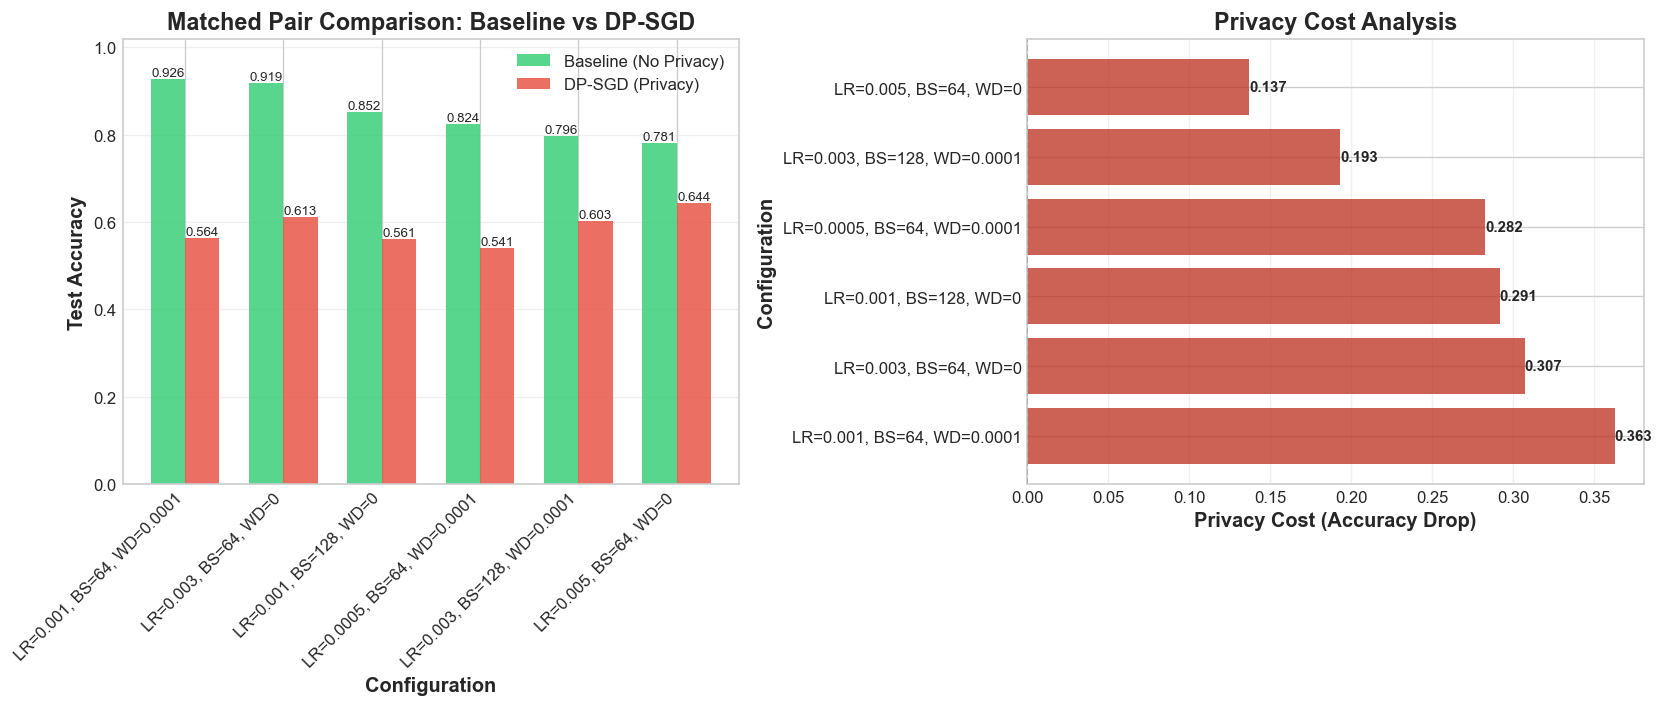

✅ Quick run comparison plot saved: 20251122_221639_matched_pair_comparison_quick.png

📊 Generating matched pair comparison for LONG runs...
📊 Matched pair comparison saved to: 20251122_221639_matched_pair_comparison_long.png


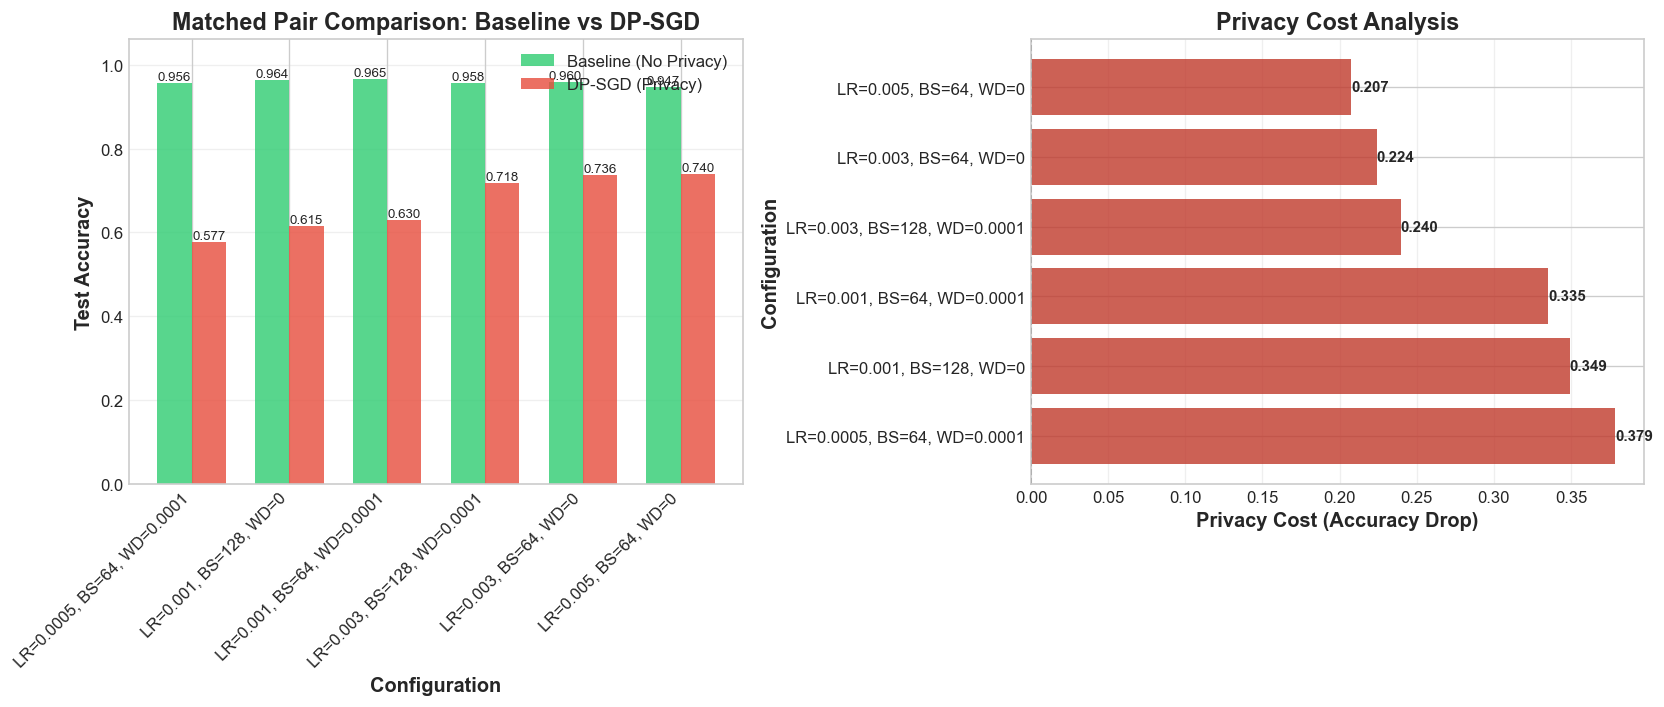

✅ Long run comparison plot saved: 20251122_221639_matched_pair_comparison_long.png


In [26]:
# --- Matched Pair Comparison: Side-by-Side Visualization ---
# Creates a comprehensive comparison showing baseline vs DP-SGD for each matched configuration.
# Enables direct quantification of privacy cost across all hyperparameter combinations.
# Dependencies: baseline_history, dp_history (set by previous cell - supports both quick and long runs)

from src.training import plot_matched_pair_comparison
from src.notebooks import generate_timestamp

# Check for both quick and long training histories
has_long_baseline = 'history_df_long' in globals()
has_long_dp = 'dp_history_df_long' in globals()
has_quick_baseline = 'history_df_quick' in globals()
has_quick_dp = 'dp_history_df_quick' in globals()

# Determine which pairs are available
has_quick_pair = has_quick_baseline and has_quick_dp
has_long_pair = has_long_baseline and has_long_dp

# Validate that we have at least one complete pair
if not has_quick_pair and not has_long_pair:
    print("❌ Missing required training histories. Please run the training cells first.")
    print("   You need at least one complete pair (baseline + DP-SGD) from either:")
    print("   • Quick Run Baseline Training (Cell 21) + Quick Run DP-SGD Training (Cell 25)")
    print("   • Long Run Baseline Training (Cell 22) + Long Run DP-SGD Training (Cell 26)")
    raise RuntimeError("Missing required training histories")

# Display what we found
print("✅ Generating matched pair comparisons:")
if has_quick_pair:
    print(f"   • Quick pair: {len(history_df_quick)} baseline records, {len(dp_history_df_quick)} DP-SGD records")
if has_long_pair:
    print(f"   • Long pair: {len(history_df_long)} baseline records, {len(dp_history_df_long)} DP-SGD records")
if has_quick_pair and has_long_pair:
    print("   ℹ️  Both quick and long pairs detected. Generating comparisons for both...")
elif has_quick_pair:
    print("   ℹ️  Using quick run data for matched pair comparison.")
elif has_long_pair:
    print("   ℹ️  Using long run data for matched pair comparison.")

# Generate comparisons for all available pairs
timestamp = generate_timestamp()

if has_quick_pair:
    print("\n📊 Generating matched pair comparison for QUICK runs...")
    filename_quick = f"{timestamp}_matched_pair_comparison_quick.png"
    fig_quick = plot_matched_pair_comparison(
        baseline_history=history_df_quick,
        dp_history=dp_history_df_quick,
        save_path=filename_quick
    )
    print(f"✅ Quick run comparison plot saved: {filename_quick}")

if has_long_pair:
    print("\n📊 Generating matched pair comparison for LONG runs...")
    filename_long = f"{timestamp}_matched_pair_comparison_long.png"
    fig_long = plot_matched_pair_comparison(
        baseline_history=history_df_long,
        dp_history=dp_history_df_long,
        save_path=filename_long
    )
    print(f"✅ Long run comparison plot saved: {filename_long}")


## <a id="summary"></a>6. Summary

This notebook compared baseline and DP-SGD training on the CelebA eyeglasses classification task using matched hyperparameters to isolate the privacy-accuracy trade-off.

**Key findings:**
- Privacy-accuracy trade-off: DP-SGD provides differential privacy guarantees at the cost of some accuracy
- Hyperparameter sensitivity: Different configurations respond differently to privacy mechanisms
- Matched pair methodology: Using identical hyperparameters enables direct quantification of privacy cost

**Key metrics:**
- Privacy cost: Accuracy difference between baseline and DP-SGD for each configuration
- Epsilon (ε): Privacy budget consumed (lower values = stronger privacy guarantees)
- Configuration performance: Some hyperparameter combinations achieve better privacy-accuracy balance

**Extensions:**
- Explore different privacy parameters (`noise_multiplier`, `max_grad_norm`)
- Longer training runs (uncomment 15-epoch cells for full convergence)
- Different attributes (explore how privacy costs vary with task difficulty)
- Architecture exploration (test which models are more privacy-friendly)
- Advanced techniques: [PATE (Papernot et al., 2017)](https://arxiv.org/abs/1611.01277), [Federated Learning (McMahan et al., 2017)](https://arxiv.org/abs/1602.05629), [Private Aggregation of Teacher Ensembles](https://github.com/tensorflow/privacy/tree/master/research/pate_2017)

**Resources:**

**Foundational Papers:**
- Differential Privacy: [Dwork & Roth (2014) - Textbook](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) | [Dwork (2006) - Original Paper](https://www.microsoft.com/en-us/research/publication/differential-privacy/)
- DP-SGD: [Abadi et al. (2016) - Deep Learning with Differential Privacy](https://arxiv.org/abs/1607.00133)
- Privacy Attacks: [Shokri et al. (2017) - Membership Inference](https://arxiv.org/abs/1610.05820) | [Fredrikson et al. (2015) - Model Inversion](https://www.cs.cmu.edu/~mfredrik/papers/fjr2015ccs.pdf)

**Implementation Libraries:**
- [Opacus - PyTorch Privacy Library](https://opacus.ai/) - Official library for DP-SGD in PyTorch
- [Opacus Documentation & Tutorials](https://opacus.ai/api/) - API reference and getting started guides
- [TensorFlow Privacy](https://github.com/tensorflow/privacy) - DP-SGD implementation for TensorFlow

**Privacy Accounting:**
- [Rényi Differential Privacy (Mironov, 2017)](https://arxiv.org/abs/1702.07476) - Advanced privacy accounting used by Opacus
- [Moments Accountant (Abadi et al., 2016)](https://arxiv.org/abs/1607.00133) - Privacy accounting method in DP-SGD

**Additional Learning:**
- [NIST Privacy Engineering Guide](https://www.nist.gov/publications/differential-privacy-sharing-practices) - Practical guidance on differential privacy
- [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) - Large-scale face attributes dataset

**Note:** Privacy is a property of the training algorithm, not the trained model. Privacy guarantees apply to the training data, not to inference on new examples.
